## Script #2: Calculate LAA for HAA9 and HAA5


__Author__: Billy Raseman

__Purpose__: calculate locational annual average (LAA) for HAA9 and HAA5 and output the mass concentration and calculated additive toxicity (CAT) for both.

- Input: HAA group-level occurrence (script #1 output)
- Intermediate results: plots related to HAA5 and HAA9 occurrence
- Output: HAA9 and HAA5 LAA values

In [261]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans  # clustering
import statsmodels.api as sm  # linear regression

### User inputs

In [262]:
# File paths
## Inputs
path_haa_grp_occur = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\jupyter\sprint_6_manuscript\output\foia_grp_occur_CAT_molarc_BSF.csv'
path_dim = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\data\haa9_dimension_table.csv'
path_haa_species_occur = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\jupyter\sprint_6_manuscript\output\foia_species_occur.csv'
path_pwsid_zipcode = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\data\UCMR4\UCMR4_ZipCodes.txt'
path_trt_dis = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\data\UCMR4\UCMR4_HAA_AddtlDataElem.txt'
path_source_wq = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\data\UCMR4\UCMR4_HAA_Indicators.txt'

## Outputs
path_output_laa = r'C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\jupyter\sprint_6_manuscript\output\foia_calc_grp_laa.csv'

# Calculation assumptions
value_belowMRL = 0  # assume that any non-detects are equivalent to zero ug/L

# MRLs (ug/L) for EPA 552.3
MRL_MBAA = 0.3  
MRL_MCAA = 2.0  

# MCLs (ug/L)
HAA5_MCL = 60

# Exclude MBAA and MCAA?
exclude_mHAAs = False

# Treatment technologies to consider
trt_tech = ['GAC', 'IEX', 'BIO']

In [263]:
# Add DBP abbreviations to the dataset
haa_dict = {
    "monobromoacetic acid": "MBAA",
    "monochloroacetic acid": "MCAA",
    "dibromoacetic acid": "DBAA",
    "dichloroacetic acid": "DCAA",
    "bromochloroacetic acid": "BCAA",
    "tribromoacetic acid": "TBAA",
    "trichloroacetic acid": "TCAA",
    "chlorodibromoacetic acid": "CDBAA",
    "bromodichloroacetic acid": "BDCAA"
}  # chemical compound name and abbreviation dictionary

### Read HAA group occurrence data

In [264]:
df_grp = pd.read_csv(path_haa_grp_occur)

In [265]:
# Keep columns needed for analysis
df_grp = df_grp[['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode',
       'CalculatedResultValue(µg/L)', 'Group']]

### Transform data and calculate LAA for each utility (PWSID)
- Step 1) convert data to wide format and summarize
- Step 2) get the average across sampling events for each sample (mimics the LAA)
- Step 3) calculate maximum locational annual averages for each PWSID for HAA9 and HAA5

In [266]:
# Convert to wide format
df_grp_wide = df_grp.pivot(index=['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode'], columns='Group', values='CalculatedResultValue(µg/L)').reset_index()
df_grp_wide['FacilityID'] = df_grp_wide['FacilityID'].apply(str)
df_grp_wide.head()

Group,PWSID,FacilityID,SamplePointID,SampleEventCode,HAA5,HAA6Br,HAA9,dHAA,mHAA,tHAA
0,010106001,1,D12,SEH1,10.882,16.800,17.342,11.632,1.390,4.320
1,010106001,1,D12,SEH2,0.748,0.748,0.748,0.748,0.000,0.000
2,010106001,1,D12,SEH3,11.240,21.970,25.160,12.300,1.280,11.580
3,010106001,1,D12,SEH4,8.083,18.754,18.754,7.771,0.953,10.030
4,010106001,1,D19,SEH1,3.751,4.756,5.193,4.184,0.504,0.505


In [267]:
# Statistics for all sampling events at all sampling locations
df_grp_wide.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.1f}'.format)

Group,HAA5,HAA6Br,HAA9,dHAA,mHAA,tHAA
count,"63,495.0","63,495.0","63,495.0","63,495.0","63,495.0","63,495.0"
mean,19.0,7.2,24.9,12.9,0.6,11.4
std,17.6,8.6,21.3,11.1,2.1,11.5
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,6.5,2.5,10.7,5.6,0.0,3.1
50%,15.6,5.4,22.4,11.4,0.0,9.3
75%,27.0,9.5,34.7,18.0,0.4,16.3
90%,39.4,15.3,48.1,25.0,2.2,24.5
95%,48.1,20.5,58.1,30.3,3.3,30.6
97%,55.0,24.4,65.7,34.1,4.2,35.5


#### Calculate mean concentration for each sampling location across sampling events

In [268]:
df_grp_laa = df_grp_wide.groupby(['PWSID', 'FacilityID', 'SamplePointID'], 
                        as_index=False).mean()

In [269]:
# Statistics for average concentration at each sampling location
df_grp_laa.describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.1f}'.format)

Group,HAA5,HAA6Br,HAA9,dHAA,mHAA,tHAA
count,"19,166.0","19,166.0","19,166.0","19,166.0","19,166.0","19,166.0"
mean,17.2,6.9,22.8,11.9,0.6,10.4
std,14.8,6.9,17.7,9.2,1.3,9.6
min,0.0,0.0,0.0,0.0,0.0,0.0
50%,14.7,5.4,21.6,11.1,0.1,8.7
90%,36.2,14.5,44.4,22.8,1.6,22.8
95%,42.8,19.1,51.9,26.5,2.5,27.7
97%,47.6,22.2,57.3,29.8,3.4,31.4
98%,51.1,24.6,61.5,32.3,4.1,34.2
99%,57.8,29.7,70.2,38.2,5.9,39.0


#### Maximum LAA: calculate maximum locational annual averages for each PWSID for HAA5, HAA6Br, and HAA9

In [270]:
df_mlaa_noloc = df_grp_laa[['PWSID', 'FacilityID', 'SamplePointID', 'HAA9', 'HAA5', 'HAA6Br']]
df_mlaa_noloc = df_mlaa_noloc.groupby(['PWSID'], as_index=False).max().drop(columns=['FacilityID', 'SamplePointID'])  # calculate LAA for HAA5 and HAA9
# NOTE: the FacilityID and SamplePointID returned from the groupby are meaningless and should be removed

In [271]:
# Statistics for average concentration at each sampling location (LAA) - no location information provided (SampleLocationID)
df_mlaa_noloc.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.1f}'.format)

Group,HAA9,HAA5,HAA6Br
count,"4,924.0","4,924.0","4,924.0"
mean,24.2,18.4,7.5
std,20.1,17.0,7.6
min,0.0,0.0,0.0
25%,7.2,4.2,2.5
50%,22.3,14.8,5.9
75%,36.2,28.2,9.9
90%,49.1,40.4,16.0
95%,57.4,47.3,21.1
97%,63.3,52.4,24.9


In [272]:
# Get location data associated with the maximum LAA using idxmax() method
# source: https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby
df_grp_laa_haa569 = df_grp_laa[['PWSID', 'FacilityID', 'SamplePointID', 'HAA9', 'HAA5', 'HAA6Br']]
idx_mlaa_haa9 = df_grp_laa_haa569.groupby(['PWSID'])['HAA9'].idxmax()  # return the index (row number) associated with the maximum LAA for HAA9
idx_mlaa_haa5 = df_grp_laa_haa569.groupby(['PWSID'])['HAA5'].idxmax()  # return the index (row number) associated with the maximum LAA for HAA5
idx_mlaa_haa6Br = df_grp_laa_haa569.groupby(['PWSID'])['HAA6Br'].idxmax()  # return the index (row number) associated with the maximum LAA for HAA6Br

In [273]:
def count_series_matches(s1, s2):
    # compare the Series
    matches = (s1 == s2)
    mismatches = ~(s1 == s2)  # use the ~ operator to negate the Boolean Series

    # count the number of matches and mismatches
    num_matches = matches.value_counts()[True]
    num_mismatches = mismatches.value_counts()[True]

    # print the results
    print("Number of matches:", num_matches)
    print("Number of mismatches:", num_mismatches)

print("Comparing HAA9 and HAA6Br max LAA monitoring locations...")
count_series_matches(idx_mlaa_haa9, idx_mlaa_haa6Br)
print("")

print("Comparing HAA9 and HAA5 max LAA monitoring locations...")
count_series_matches(idx_mlaa_haa9, idx_mlaa_haa5)
print("")

print("Comparing HAA5 and HAA6Br max LAA monitoring locations...")
count_series_matches(idx_mlaa_haa5, idx_mlaa_haa6Br)

Comparing HAA9 and HAA6Br max LAA monitoring locations...
Number of matches: 3671
Number of mismatches: 1253

Comparing HAA9 and HAA5 max LAA monitoring locations...
Number of matches: 4543
Number of mismatches: 381

Comparing HAA5 and HAA6Br max LAA monitoring locations...
Number of matches: 3369
Number of mismatches: 1555


In [274]:
# Export for QAQC (HAA5 and HAA9)
df_grp_laa_haa569.rename(columns={'HAA9':'Max LAA HAA9 (ug/L)', 'HAA5':'Max LAA HAA5 (ug/L)', 'HAA6Br':'Max LAA HAA6Br (ug/L)'}).to_csv('./output/HAA56Br9-grp_max-LAA_incl-IDs_UMCR4-FOIA.csv', index=False)

In [275]:
# Maximum LAA for HAA9 with assocated PWSID, FacilityID, and SamplePointID
df_mlaa_haa9 = df_grp_laa_haa569.loc[idx_mlaa_haa9,].drop(columns=['HAA5','HAA6Br']).rename(columns={'HAA9':'Max LAA HAA9 (ug/L)'})
df_mlaa_haa9

Group,PWSID,FacilityID,SamplePointID,Max LAA HAA9 (ug/L)
2,010106001,1,D6,43.17250
7,010109005,4,SC4,59.81400
8,055293201,67890,DS1,4.88050
11,055294214,30001,DS2,0.65000
12,055294506,99001,DS001,1.58700
...,...,...,...,...
19158,WY5600150,90001,S2PBLCWRKS,58.57750
19159,WY5600847,30001,DS1,45.70750
19161,WY5601181,1181,DBPR2,22.29575
19162,WY5601182,13659,S2WYBVRGE,34.84000


In [276]:
# Export for QAQC
df_mlaa_haa9.to_csv('./output/HAA9-grp_max-LAA_incl-IDs_UMCR4-FOIA.csv', index=False)

In [277]:
# Maximum LAA for HAA5 with assocated PWSID, FacilityID, and SamplePointID
df_mlaa_haa5 = df_grp_laa_haa569.loc[idx_mlaa_haa5,].drop(columns=['HAA9', 'HAA6Br']).rename(columns={'HAA5':'Max LAA HAA5 (ug/L)'})
df_mlaa_haa5

Group,PWSID,FacilityID,SamplePointID,Max LAA HAA5 (ug/L)
2,010106001,1,D6,24.52500
7,010109005,4,SC4,54.58025
8,055293201,67890,DS1,2.37000
11,055294214,30001,DS2,0.42500
12,055294506,99001,DS001,1.04800
...,...,...,...,...
19158,WY5600150,90001,S2PBLCWRKS,44.75450
19159,WY5600847,30001,DS1,34.84000
19161,WY5601181,1181,DBPR2,16.17725
19162,WY5601182,13659,S2WYBVRGE,28.41250


In [278]:
# Export for QAQC
df_mlaa_haa5.to_csv('./output/HAA5-grp_max-LAA_incl-IDs_UMCR4-FOIA.csv', index=False)

In [279]:
# Maximum LAA for HAA6Br with assocated PWSID, FacilityID, and SamplePointID
df_mlaa_haa6Br = df_grp_laa_haa569.loc[idx_mlaa_haa6Br,].drop(columns=['HAA9','HAA5']).rename(columns={'HAA6Br':'Max LAA HAABr (ug/L)'})
df_mlaa_haa6Br

Group,PWSID,FacilityID,SamplePointID,Max LAA HAABr (ug/L)
2,010106001,1,D6,21.0150
7,010109005,4,SC4,5.3115
8,055293201,67890,DS1,4.6715
11,055294214,30001,DS2,0.2250
12,055294506,99001,DS001,0.6905
...,...,...,...,...
19158,WY5600150,90001,S2PBLCWRKS,14.4725
19159,WY5600847,30001,DS1,11.7075
19161,WY5601181,1181,DBPR2,7.2360
19162,WY5601182,13659,S2WYBVRGE,6.8650


In [280]:
# Export for QAQC
df_mlaa_haa6Br.to_csv('./output/HAA6Br-grp_max-LAA_incl-IDs_UMCR4-FOIA.csv', index=False)

### Visualize Max LAA data for HAA5 and HAA9

In [281]:
df_laa_tall = df_mlaa_noloc.melt(id_vars='PWSID', var_name='Group', value_name='Max LAA (ug/L)')

In [282]:
df_laa_tall

,PWSID,Group,Max LAA (ug/L)
0,010106001,HAA9,43.1725
1,010109005,HAA9,59.8140
2,055293201,HAA9,4.8805
3,055294214,HAA9,0.6500
4,055294506,HAA9,1.5870
...,...,...,...
14767,WY5600150,HAA6Br,14.4725
14768,WY5600847,HAA6Br,11.7075
14769,WY5601181,HAA6Br,7.2360
14770,WY5601182,HAA6Br,6.8650


In [283]:
# Prepare for visualizations
epa_grp_order = ['HAA5', 'HAA9']

c:\Users\WRaseman\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(65, 0.4, 'HAA5 MCL: 60 µg/L')

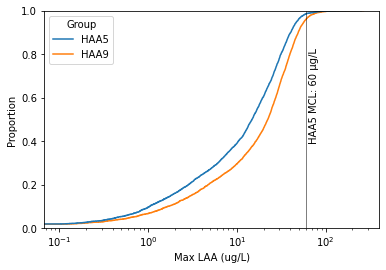

In [284]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_laa_tall, x='Max LAA (ug/L)', hue="Group", hue_order=epa_grp_order, log_scale=True)
# Label MCLs
plt.axvline(x=HAA5_MCL, color='black', linewidth=0.5)
plt.text(x=HAA5_MCL + 5, y=0.4, s='HAA5 MCL: 60 µg/L', rotation=90)

(0.95, 1.0)

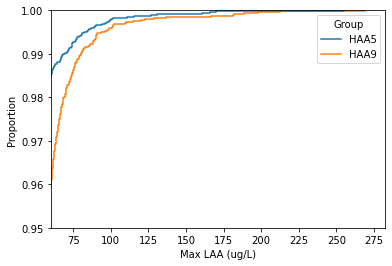

In [285]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_laa_tall, x='Max LAA (ug/L)', hue="Group", hue_order=epa_grp_order, log_scale=False)
g.set_xlim([60, None])
g.set_ylim([0.95, None])

### Get species-level data for max HAA9 LAA and visualize

In [286]:
# Read in occurrence data by species
df_species_occur = pd.read_csv(path_haa_species_occur)[[
    'PWSID', 'FacilityID', 'SamplePointID', 'Contaminant', 'CalculatedResultValue(µg/L)']]
# Calculate locational annual average by species
df_species_laa = df_species_occur.groupby(
    ['PWSID', 'FacilityID', 'SamplePointID', 'Contaminant'], 
    as_index=False).mean()
df_species_laa['Abbreviation'] = df_species_laa['Contaminant'].map(haa_dict)  # add abbreviations for DBPs
df_species_laa = df_species_laa.drop(columns='Contaminant')

In [287]:
# Convert species LAA occurrence to wide format
df_species_laa_w = df_species_laa.pivot(
    index=['PWSID', 'FacilityID', 'SamplePointID'], 
    columns='Abbreviation', 
    values='CalculatedResultValue(µg/L)').reset_index()

# display(df_species_laa_w)
display(df_species_laa_w.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19166 entries, 0 to 19165
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PWSID          19166 non-null  object 
 1   FacilityID     19166 non-null  int64  
 2   SamplePointID  19166 non-null  object 
 3   BCAA           19166 non-null  float64
 4   BDCAA          19166 non-null  float64
 5   CDBAA          19166 non-null  float64
 6   DBAA           19166 non-null  float64
 7   DCAA           19166 non-null  float64
 8   MBAA           19166 non-null  float64
 9   MCAA           19166 non-null  float64
 10  TBAA           19166 non-null  float64
 11  TCAA           19166 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.8+ MB


None

In [288]:
df_mlaa_haa9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4924 entries, 2 to 19165
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PWSID                4924 non-null   object 
 1   FacilityID           4924 non-null   object 
 2   SamplePointID        4924 non-null   object 
 3   Max LAA HAA9 (ug/L)  4924 non-null   float64
dtypes: float64(1), object(3)
memory usage: 192.3+ KB


In [289]:
# Subset dataset to get species analysis associated with maximum LAA for HAA9
df_species_laa_w['FacilityID'] = df_species_laa_w['FacilityID'].astype(str)
df_species_mlaa_w = pd.merge(left=df_mlaa_haa9, right=df_species_laa_w, how='left', validate='1:1', on=['PWSID', 'FacilityID', 'SamplePointID'])

display(df_species_mlaa_w)

,PWSID,FacilityID,SamplePointID,Max LAA HAA9 (ug/L),BCAA,BDCAA,CDBAA,DBAA,DCAA,MBAA,MCAA,TBAA,TCAA
0,010106001,1,D6,43.17250,4.71500,9.10250,2.9900,2.19000,8.0600,0.1775,1.1325,1.84,12.96500
1,010109005,4,SC4,59.81400,2.20575,2.73000,0.2980,0.07775,18.1850,0.0000,1.7175,0.00,34.60000
2,055293201,67890,DS1,4.88050,0.91100,0.00000,0.5695,1.94500,0.2090,0.2160,0.0000,1.03,0.00000
3,055294214,30001,DS2,0.65000,0.22500,0.00000,0.0000,0.00000,0.4250,0.0000,0.0000,0.00,0.00000
4,055294506,99001,DS001,1.58700,0.53900,0.00000,0.0000,0.15150,0.8965,0.0000,0.0000,0.00,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919,WY5600150,90001,S2PBLCWRKS,58.57750,5.02000,7.93000,0.8730,0.47350,16.6300,0.1760,0.0000,0.00,27.47500
4920,WY5600847,30001,DS1,45.70750,4.07500,5.72500,1.0675,0.60000,13.7250,0.2400,1.2750,0.00,19.00000
4921,WY5601181,1181,DBPR2,22.29575,2.65825,2.77875,0.6815,0.68450,8.9930,0.4330,0.0000,0.00,6.06675
4922,WY5601182,13659,S2WYBVRGE,34.84000,2.82500,3.05000,0.5525,0.43750,11.7250,0.0000,1.1750,0.00,15.07500


In [290]:
val_vars = ['BCAA', 'BDCAA', 'CDBAA', 'DBAA', 'DCAA', 'MBAA', 'MCAA', 'TBAA', 'TCAA']
index_idx = ['PWSID', 'FacilityID', 'SamplePointID']

df_species_mlaa = pd.melt(df_species_mlaa_w, 
    id_vars = index_idx, value_vars = val_vars, 
    var_name='Abbreviation', value_name='Concentration(ug/L)').reset_index(drop=True)
display(df_species_mlaa)
display(df_species_mlaa.info())

,PWSID,FacilityID,SamplePointID,Abbreviation,Concentration(ug/L)
0,010106001,1,D6,BCAA,4.71500
1,010109005,4,SC4,BCAA,2.20575
2,055293201,67890,DS1,BCAA,0.91100
3,055294214,30001,DS2,BCAA,0.22500
4,055294506,99001,DS001,BCAA,0.53900
...,...,...,...,...,...
44311,WY5600150,90001,S2PBLCWRKS,TCAA,27.47500
44312,WY5600847,30001,DS1,TCAA,19.00000
44313,WY5601181,1181,DBPR2,TCAA,6.06675
44314,WY5601182,13659,S2WYBVRGE,TCAA,15.07500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44316 entries, 0 to 44315
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PWSID                44316 non-null  object 
 1   FacilityID           44316 non-null  object 
 2   SamplePointID        44316 non-null  object 
 3   Abbreviation         44316 non-null  object 
 4   Concentration(ug/L)  44316 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


None

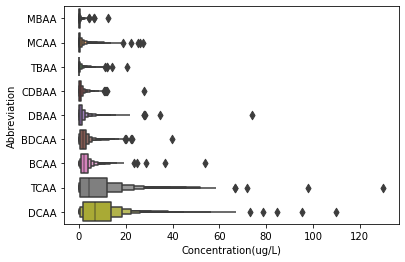

In [291]:
# Visualize boxplots of the HAA species by concentration
my_order = df_species_mlaa.groupby(by=["Abbreviation"])["Concentration(ug/L)"].median().sort_values().index
g1 = sns.boxenplot(data=df_species_mlaa, x='Concentration(ug/L)', y='Abbreviation', order=my_order)

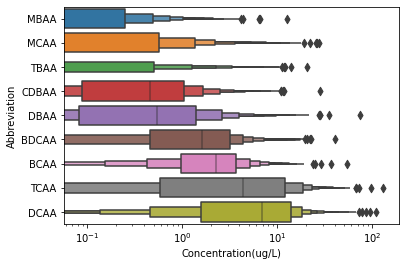

In [292]:
g2 = sns.boxenplot(data=df_species_mlaa, x='Concentration(ug/L)', y='Abbreviation', order=my_order)
g2.set_xscale("log")

### Read in data for system size and zip code

In [293]:
df_size = pd.read_csv(path_haa_species_occur)
# Keep columns needed for analysis
df_size = df_size[['PWSID', 'Size', 'State', 'Region']]
# Remove duplicates
df_size = df_size.drop_duplicates().reset_index().drop(columns='index')

In [294]:
df_size

,PWSID,Size,State,Region
0,010106001,L,01,1
1,010109005,L,01,1
2,055293201,L,05,5
3,055294214,S,05,5
4,055294506,L,05,5
...,...,...,...,...
4919,WY5600150,L,WY,8
4920,WY5600847,S,WY,8
4921,WY5601181,L,WY,8
4922,WY5601182,L,WY,8


In [295]:
df_zip = pd.read_csv(path_pwsid_zipcode, delimiter='\t')
df_zip = df_zip.groupby(['PWSID'], as_index=False).first()  # only use first zip code
df_zip['ZIPCODE'] = df_zip['ZIPCODE'].apply(str)

In [296]:
df_zip

,PWSID,ZIPCODE
0,010106001,6338
1,010109005,6382
2,020000008,14129
3,043740039,28719
4,055293201,48858
...,...,...
5120,WY5601254,82435
5121,WY5601391,82902
5122,WY5601415,82604
5123,WY5601537,82801


In [297]:
# Combine system size and zip code information with PWSID
df_size_zip = pd.merge(left=df_size, right=df_zip, on='PWSID', how='left')

In [298]:
df_size_zip

,PWSID,Size,State,Region,ZIPCODE
0,010106001,L,01,1,6338
1,010109005,L,01,1,6382
2,055293201,L,05,5,48858
3,055294214,S,05,5,56633
4,055294506,L,05,5,55372
...,...,...,...,...,...
4919,WY5600150,L,WY,8,82931
4920,WY5600847,S,WY,8,82939
4921,WY5601181,L,WY,8,82935
4922,WY5601182,L,WY,8,82901


In [299]:
# There are 665 PWSIDs in the dataset that do NOT have zip codes
df_size_zip.isna().sum()

PWSID        0
Size         0
State        0
Region       0
ZIPCODE    665
dtype: int64

### Combine LAA data with system size and zip code information

In [300]:
df_laa_size_zip = pd.merge(left=df_laa_tall, right=df_size_zip, on='PWSID', how='left')

In [301]:
# Convert to wide format
df_laa_size_zip_wd = df_laa_size_zip.pivot(index=['PWSID', 'Size', 'State', 'Region', 'ZIPCODE'], columns='Group', values='Max LAA (ug/L)').reset_index()
df_laa_size_zip_wd

Group,PWSID,Size,State,Region,ZIPCODE,HAA5,HAA6Br,HAA9
0,010106001,L,01,1,6338,24.52500,21.0150,43.17250
1,010109005,L,01,1,6382,54.58025,5.3115,59.81400
2,055293201,L,05,5,48858,2.37000,4.6715,4.88050
3,055294214,S,05,5,56633,0.42500,0.2250,0.65000
4,055294506,L,05,5,55372,1.04800,0.6905,1.58700
...,...,...,...,...,...,...,...,...
4919,WY5600150,L,WY,8,82931,44.75450,14.4725,58.57750
4920,WY5600847,S,WY,8,82939,34.84000,11.7075,45.70750
4921,WY5601181,L,WY,8,82935,16.17725,7.2360,22.29575
4922,WY5601182,L,WY,8,82901,28.41250,6.8650,34.84000


In [302]:
# How many utilities... (group by large and Large utilities)
#   - HAA9 > 72 ug/L
#   - HAA9 > 60 ug/L
#   - HAA9 > 48 ug/L
df_small = df_laa_size_zip_wd[df_laa_size_zip_wd['Size'] == 'S']

# Small utilities
pwsids_total_small = len(df_small.index)
pwsids_72_small = len(df_small[df_small['HAA9'] > 72].index)
pwsids_60_small = len(df_small[df_small['HAA9'] > 60].index)
pwsids_48_small = len(df_small[df_small['HAA9'] > 48].index)

pwsids_60_small5 = len(df_small[df_small['HAA5'] > 60].index)
pwsids_48_small5 = len(df_small[df_small['HAA5'] > 48].index)

print(f"Small systems: {pwsids_72_small} out of {pwsids_total_small} PWSIDs have HAA9 Max LAA > 72 ug/L, or {pwsids_72_small/pwsids_total_small*100:.1f}%")
print(f"Small systems: {pwsids_60_small} out of {pwsids_total_small} PWSIDs have HAA9 Max LAA > 60 ug/L, or {pwsids_60_small/pwsids_total_small*100:.1f}%")
print(f"Small systems: {pwsids_48_small} out of {pwsids_total_small} PWSIDs have HAA9 Max LAA > 48 ug/L, or {pwsids_48_small/pwsids_total_small*100:.1f}%")
print(f"Small systems: {pwsids_60_small5} out of {pwsids_total_small} PWSIDs have HAA5 Max LAA > 60 ug/L, or {pwsids_60_small5/pwsids_total_small*100:.1f}%")
print(f"Small systems: {pwsids_48_small5} out of {pwsids_total_small} PWSIDs have HAA5 Max LAA > 48 ug/L, or {pwsids_48_small5/pwsids_total_small*100:.1f}%")

Small systems: 12 out of 727 PWSIDs have HAA9 Max LAA > 72 ug/L, or 1.7%
Small systems: 28 out of 727 PWSIDs have HAA9 Max LAA > 60 ug/L, or 3.9%
Small systems: 56 out of 727 PWSIDs have HAA9 Max LAA > 48 ug/L, or 7.7%
Small systems: 11 out of 727 PWSIDs have HAA5 Max LAA > 60 ug/L, or 1.5%
Small systems: 31 out of 727 PWSIDs have HAA5 Max LAA > 48 ug/L, or 4.3%


In [303]:
# Large utilities
df_large = df_laa_size_zip_wd[df_laa_size_zip_wd['Size'] == 'L']

pwsids_total_large = len(df_large.index)
pwsids_72_large = len(df_large[df_large['HAA9'] > 72].index)
pwsids_60_large = len(df_large[df_large['HAA9'] > 60].index)
pwsids_48_large = len(df_large[df_large['HAA9'] > 48].index)

pwsids_60_large5 = len(df_large[df_large['HAA5'] > 60].index)
pwsids_48_large5 = len(df_large[df_large['HAA5'] > 48].index)

print(f"Large systems: {pwsids_72_large} out of {pwsids_total_large} PWSIDs have HAA9 Max LAA > 72 ug/L, or {pwsids_72_large/pwsids_total_large*100:.1f}%")
print(f"Large systems: {pwsids_60_large} out of {pwsids_total_large} PWSIDs have HAA9 Max LAA > 60 ug/L, or {pwsids_60_large/pwsids_total_large*100:.1f}%")
print(f"Large systems: {pwsids_48_large} out of {pwsids_total_large} PWSIDs have HAA9 Max LAA > 48 ug/L, or {pwsids_48_large/pwsids_total_large*100:.1f}%")
print(f"Large systems: {pwsids_60_large5} out of {pwsids_total_large} PWSIDs have HAA5 Max LAA > 60 ug/L, or {pwsids_60_large5/pwsids_total_large*100:.1f}%")
print(f"Large systems: {pwsids_48_large5} out of {pwsids_total_large} PWSIDs have HAA5 Max LAA > 48 ug/L, or {pwsids_48_large5/pwsids_total_large*100:.1f}%")

Large systems: 72 out of 4197 PWSIDs have HAA9 Max LAA > 72 ug/L, or 1.7%
Large systems: 173 out of 4197 PWSIDs have HAA9 Max LAA > 60 ug/L, or 4.1%
Large systems: 488 out of 4197 PWSIDs have HAA9 Max LAA > 48 ug/L, or 11.6%
Large systems: 63 out of 4197 PWSIDs have HAA5 Max LAA > 60 ug/L, or 1.5%
Large systems: 206 out of 4197 PWSIDs have HAA5 Max LAA > 48 ug/L, or 4.9%


### Calculate CAT and Concentration for LAA for HAA5 and HAA9

In [304]:
# Read in group data again
df_grp2 = pd.read_csv(path_haa_grp_occur)
df_grp2 = df_grp2[df_grp2['Group'].isin(['HAA5', 'HAA9'])]
df_grp2.columns

Index(['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode',
       'CalculatedResultValue(µg/L)', 'MolarConc(mol/L)', 'CAT', 'Group',
       'BSF'],
      dtype='object')

In [305]:
df_grp2

,PWSID,FacilityID,SamplePointID,SampleEventCode,CalculatedResultValue(µg/L),MolarConc(mol/L),CAT,Group,BSF
0,010106001,1,D12,SEH1,10.882,5.529182e-08,1.145370,HAA5,NaN
1,010106001,1,D12,SEH2,0.748,3.433650e-09,0.006300,HAA5,NaN
2,010106001,1,D12,SEH3,11.240,6.308466e-08,1.044305,HAA5,NaN
3,010106001,1,D12,SEH4,8.083,3.958852e-08,0.793342,HAA5,NaN
4,010106001,1,D19,SEH1,3.751,1.991567e-08,0.411833,HAA5,NaN
...,...,...,...,...,...,...,...,...,...
190480,WY5601415,90002,DIS001,SEH4,9.322,NaN,0.067623,HAA9,NaN
190481,WY5601415,90002,DIS002,SEH1,14.600,NaN,0.099761,HAA9,NaN
190482,WY5601415,90002,DIS002,SEH2,11.172,NaN,0.031852,HAA9,NaN
190483,WY5601415,90002,DIS002,SEH3,21.030,NaN,0.109242,HAA9,NaN


In [306]:
# Calculate LAA for HAA5 and HAA9 and get PWSID, FacilityID, and SamplePointID associated with each
df_laa_wloc = df_grp2.groupby(['PWSID', 'FacilityID', 'SamplePointID', 'Group'], 
                        as_index=False).mean()

In [307]:
df_max_laa = df_laa_wloc.groupby(['PWSID', 'Group'], as_index=False).max().drop(columns=['FacilityID', 'SamplePointID', 'BSF'])  # calculate maximum LAA for HAA5 and HAA9
# NOTE: the FacilityID and SamplePointID returned from the groupby are meaningless and should be removed

#### NOTE: this line of thinking assumes that the maximum LAA for CAT and LAA for concentration occurr at the same sampling location. This is not necessarily true.

In [308]:
df_max_laa

,PWSID,Group,CalculatedResultValue(µg/L),MolarConc(mol/L),CAT
0,010106001,HAA5,24.52500,1.651829e-07,0.747329
1,010106001,HAA9,43.17250,NaN,0.817932
2,010109005,HAA5,54.58025,3.713504e-07,0.060361
3,010109005,HAA9,59.81400,NaN,0.099703
4,055293201,HAA5,2.37000,1.318884e-08,0.182757
...,...,...,...,...,...
9843,WY5601181,HAA9,22.29575,NaN,0.402637
9844,WY5601182,HAA5,28.41250,1.976502e-07,0.087471
9845,WY5601182,HAA9,34.84000,NaN,0.125164
9846,WY5601415,HAA5,7.82825,5.521448e-08,0.015106


In [309]:
# Export for QAQC
df_max_laa.to_csv('./output/HAA59-grp_max-LAA_CAT_UMCR4-FOIA.csv', index=False)

### Visualize CAT and concentration for HAA9 and HAA5 for max LAA data

c:\Users\WRaseman\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[Text(0.5, 0, 'Max LAA CAT (µg/L)')]

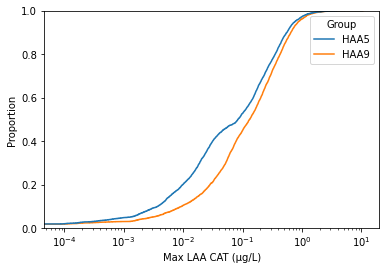

In [310]:
# Visualize CAT
g = sns.ecdfplot(data=df_max_laa, x="CAT", hue="Group", log_scale=True)
g.set(xlabel='Max LAA CAT (µg/L)')


c:\Users\WRaseman\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(65, 0.4, 'HAA5 MCL: 60 µg/L')

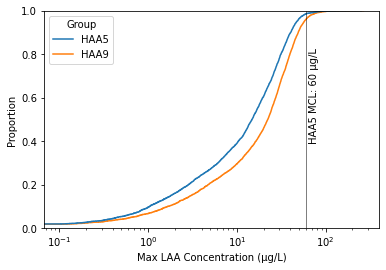

In [311]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_max_laa, x="CalculatedResultValue(µg/L)", hue="Group", hue_order=epa_grp_order, log_scale=True)
g.set(xlabel='Max LAA Concentration (µg/L)')
# Label MCLs
plt.axvline(x=HAA5_MCL, color='black', linewidth=0.5)
plt.text(x=HAA5_MCL + 5, y=0.4, s='HAA5 MCL: 60 µg/L', rotation=90)

(0.95, 1.0)

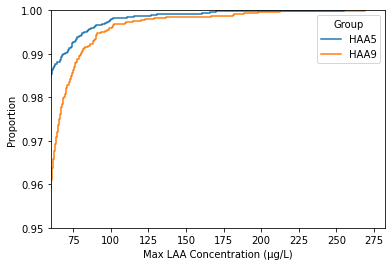

In [312]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_max_laa, x="CalculatedResultValue(µg/L)", hue="Group", hue_order=epa_grp_order, log_scale=False)
g.set(xlabel='Max LAA Concentration (µg/L)')
g.set_xlim([60, None])
g.set_ylim([0.95, None])

### Investigate correlation of concentration and CAT for HAA9 maximum LAA 

In [313]:
# Filter dataframes
df_max_laa_haa9 = df_max_laa[df_max_laa['Group'] == 'HAA9'].rename(columns={'CalculatedResultValue(µg/L)':'Max LAA Concentration (µg/L)', 'CAT':'Max LAA CAT'})
# df_max_laa_haa5 = df_max_laa[df_max_laa['Group'] == 'HAA5'].rename(columns={'CalculatedResultValue(µg/L)':'Max LAA Concentration (µg/L)', 'CAT':'Max LAA CAT'})

In [314]:
# Linear regression to get R^2
mod = sm.OLS(df_max_laa_haa9['Max LAA Concentration (µg/L)'], df_max_laa_haa9['Max LAA CAT'])
res = mod.fit()
print(res.summary())

                                      OLS Regression Results                                     
Dep. Variable:     Max LAA Concentration (µg/L)   R-squared (uncentered):                   0.392
Model:                                      OLS   Adj. R-squared (uncentered):              0.392
Method:                           Least Squares   F-statistic:                              3179.
Date:                          Mon, 27 Feb 2023   Prob (F-statistic):                        0.00
Time:                                  14:05:59   Log-Likelihood:                         -22745.
No. Observations:                          4924   AIC:                                  4.549e+04
Df Residuals:                              4923   BIC:                                  4.550e+04
Df Model:                                     1                                                  
Covariance Type:                      nonrobust                                                  
                  co

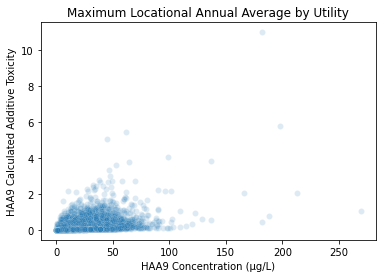

In [315]:
plt.figure()
g = sns.scatterplot(data=df_max_laa_haa9, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', alpha=0.15)
# g.set(title='HAA9, R^2 = 0.39')
g.set(title='Maximum Locational Annual Average by Utility')
g.set(xlabel='HAA9 Concentration (µg/L)', ylabel='HAA9 Calculated Additive Toxicity')
plt.savefig('HAA9_conc-v-cat.png', dpi=900) # Save that figure

In [316]:
# Export data
# df_max_laa_haa9.to_csv(r"C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Marketing\HAA9_CATvConc_ToGraphics.csv")

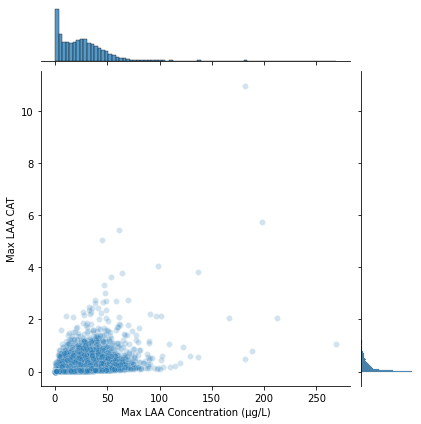

In [317]:
g = sns.jointplot(data=df_max_laa_haa9, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', alpha=0.2)

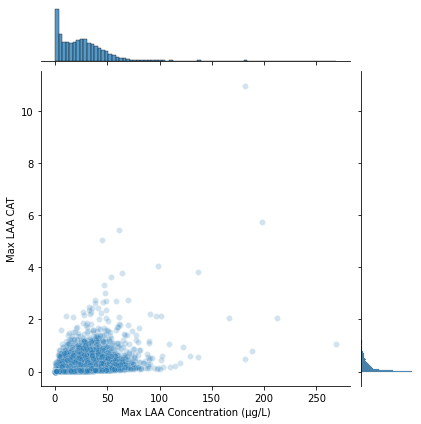

In [318]:
g = sns.jointplot(data=df_max_laa_haa9, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', alpha=0.2)

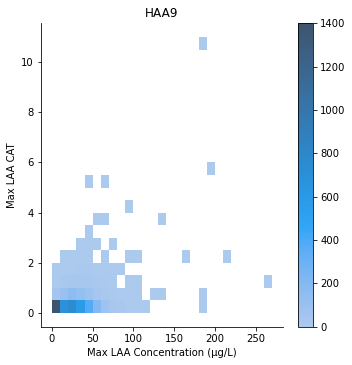

In [319]:
g = sns.displot(data=df_max_laa_haa9, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', binwidth=(10, 0.5), cbar=True)
g.set(title='HAA9')

### Screen out PWSIDs with existing HAA5 or THM violations

In [320]:
# Read in violation data from statistical surrogate from state data
path_viol = r"C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Python\UCMR4_FOIA_CTI\jupyter\sprint_4\output\corona_raa95_viol.csv"
df_viol = pd.read_csv(path_viol)

In [321]:
# Review violation data
df_viol.head()

,PWSID,HAA5_RAAQ95,HAA9_RAAQ95,TTHM_RAAQ95,HAA5_MCL,TTHM_MCL,STG2_MCL
0,010106001,24.576900,44.993200,NaN,<,?,Uncertain (No TTHM Data)
1,010109005,59.011187,64.375838,NaN,<,?,Uncertain (No TTHM Data)
2,055293201,2.579400,5.306875,NaN,<,?,Uncertain (No TTHM Data)
3,055294214,0.409000,0.622750,NaN,<,?,Uncertain (No TTHM Data)
4,055294506,1.046125,1.561425,NaN,<,?,Uncertain (No TTHM Data)


In [322]:
# Combine violation information with HAA9 data
df_max_laa_haa9_3 = pd.merge(left = df_max_laa_haa9, right = df_viol, on="PWSID", how="left")
df_max_laa_haa9_3.head()

,PWSID,Group,Max LAA Concentration (µg/L),MolarConc(mol/L),Max LAA CAT,HAA5_RAAQ95,HAA9_RAAQ95,TTHM_RAAQ95,HAA5_MCL,TTHM_MCL,STG2_MCL
0,010106001,HAA9,43.1725,NaN,0.817932,24.576900,44.993200,NaN,<,?,Uncertain (No TTHM Data)
1,010109005,HAA9,59.8140,NaN,0.099703,59.011187,64.375838,NaN,<,?,Uncertain (No TTHM Data)
2,055293201,HAA9,4.8805,NaN,0.207178,2.579400,5.306875,NaN,<,?,Uncertain (No TTHM Data)
3,055294214,HAA9,0.6500,NaN,0.002015,0.409000,0.622750,NaN,<,?,Uncertain (No TTHM Data)
4,055294506,HAA9,1.5870,NaN,0.006002,1.046125,1.561425,NaN,<,?,Uncertain (No TTHM Data)


<AxesSubplot:xlabel='HAA9_RAAQ95', ylabel='Max LAA Concentration (µg/L)'>

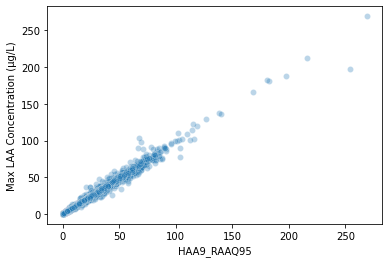

In [323]:
# Check that HAA9 max LRAA and surrogate are well correlated
sns.scatterplot(data=df_max_laa_haa9_3, x='HAA9_RAAQ95', y='Max LAA Concentration (µg/L)', alpha=0.3)
# They are!


[Text(0.5, 0, 'HAA9 Concentration (µg/L)'),
 Text(0, 0.5, 'HAA9 Calculated Additive Toxicity')]

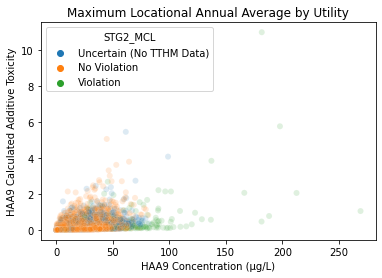

In [324]:
# Map violation data onto the results
g = sns.scatterplot(data=df_max_laa_haa9_3, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', alpha=0.15, hue='STG2_MCL')
g.set(title='Maximum Locational Annual Average by Utility')
g.set(xlabel='HAA9 Concentration (µg/L)', ylabel='HAA9 Calculated Additive Toxicity')

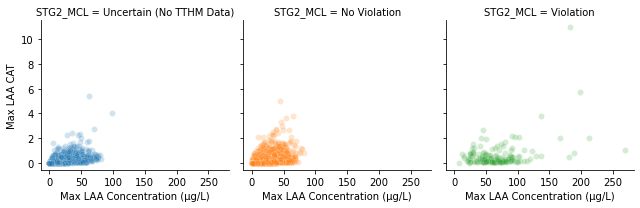

In [325]:
g = sns.FacetGrid(df_max_laa_haa9_3, col="STG2_MCL", hue="STG2_MCL")
g.map(sns.scatterplot, 'Max LAA Concentration (µg/L)', 'Max LAA CAT', alpha = 0.2)

In [326]:
df_max_laa_haa9_3['STG2_MCL'].value_counts()

No Violation                3559
Uncertain (No TTHM Data)    1188
Violation                    177
Name: STG2_MCL, dtype: int64

In [327]:
# Remove values with violation from dataset
df_max_laa_haa9_4 = df_max_laa_haa9_3[df_max_laa_haa9_3['STG2_MCL'] != "Violation"]

In [328]:
# Linear regression to get R^2
mod = sm.OLS(df_max_laa_haa9_4['Max LAA Concentration (µg/L)'], df_max_laa_haa9_4['Max LAA CAT'])
res = mod.fit()
print(res.summary())

                                      OLS Regression Results                                     
Dep. Variable:     Max LAA Concentration (µg/L)   R-squared (uncentered):                   0.404
Model:                                      OLS   Adj. R-squared (uncentered):              0.403
Method:                           Least Squares   F-statistic:                              3211.
Date:                          Mon, 27 Feb 2023   Prob (F-statistic):                        0.00
Time:                                  14:06:05   Log-Likelihood:                         -21391.
No. Observations:                          4747   AIC:                                  4.278e+04
Df Residuals:                              4746   BIC:                                  4.279e+04
Df Model:                                     1                                                  
Covariance Type:                      nonrobust                                                  
                  co

In [329]:
# Investigate data with uncertain violation data
df_max_laa_haa9_3[df_max_laa_haa9_3['STG2_MCL'] == "Uncertain (No TTHM Data)"].sort_values('Max LAA Concentration (µg/L)', ascending=False).head()

,PWSID,Group,Max LAA Concentration (µg/L),MolarConc(mol/L),Max LAA CAT,HAA5_RAAQ95,HAA9_RAAQ95,TTHM_RAAQ95,HAA5_MCL,TTHM_MCL,STG2_MCL
4402,TX1780005,HAA9,98.8900,NaN,4.067585,54.643375,99.305000,NaN,<,?,Uncertain (No TTHM Data)
1090,FL5110183,HAA9,81.7000,NaN,0.359197,52.375000,81.560000,NaN,<,?,Uncertain (No TTHM Data)
3778,PR0004745,HAA9,78.9975,NaN,0.643662,51.562375,79.681250,NaN,<,?,Uncertain (No TTHM Data)
3762,PR0003772,HAA9,76.5125,NaN,0.520192,52.001625,76.391125,NaN,<,?,Uncertain (No TTHM Data)
3755,PR0003303,HAA9,76.2825,NaN,0.665972,57.916000,75.051375,NaN,<,?,Uncertain (No TTHM Data)


<AxesSubplot:xlabel='HAA5_RAAQ95', ylabel='HAA9_RAAQ95'>

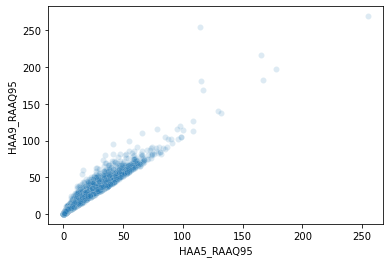

In [330]:
# Compare HAA5 and HAA9 for remaining utilities
sns.scatterplot(data = df_max_laa_haa9_3, x= 'HAA5_RAAQ95', y='HAA9_RAAQ95', alpha=0.15)

### Bin HAA9 based on CAT and analyze those systems

In [331]:
cti_name = 'Max LAA CAT'
conc_name = 'Max LAA Concentration (µg/L)'

In [332]:
# Review CAT percentiles
df_max_laa_haa9_2 = df_max_laa_haa9_4
df_max_laa_haa9_2['Max LAA CAT'].describe(percentiles=[0.9, 0.95, 0.99])

count    4747.000000
mean        0.250784
std         0.350285
min         0.000000
50%         0.124814
90%         0.637099
95%         0.851361
99%         1.564525
max         5.442221
Name: Max LAA CAT, dtype: float64

In [333]:
# Get values for percentiles
p50 = df_max_laa_haa9_2['Max LAA CAT'].quantile(0.5) # 50th percentile
p90 = df_max_laa_haa9_2['Max LAA CAT'].quantile(0.90) # 90th percentile
p99 = df_max_laa_haa9_2['Max LAA CAT'].quantile(0.99) # 99th percentile
pmax = df_max_laa_haa9_2['Max LAA CAT'].max() # maximum

# Bin the values based on percentile 
df_max_laa_haa9_2['bin'] = df_max_laa_haa9_2['Max LAA CAT'].apply(lambda x: 
    "0-50" if x <= p50 else
    "50-90" if x <= p90 else
    "90-99" if x <= p99 else "99+"
)

df_max_laa_haa9_2['cluster'] = df_max_laa_haa9_2['Max LAA CAT'].apply(lambda x: 
    "0" if x <= p50 else
    "1" if x <= p90 else
    "2" if x <= p99 else "3"
)

C:\Users\WRaseman\AppData\Local\Temp\ipykernel_22492\138473999.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_laa_haa9_2['bin'] = df_max_laa_haa9_2['Max LAA CAT'].apply(lambda x:
C:\Users\WRaseman\AppData\Local\Temp\ipykernel_22492\138473999.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_laa_haa9_2['cluster'] = df_max_laa_haa9_2['Max LAA CAT'].apply(lambda x:


In [334]:
df_max_laa_haa9_2[['PWSID', 'Max LAA CAT', 'bin']]

,PWSID,Max LAA CAT,bin
0,010106001,0.817932,90-99
1,010109005,0.099703,0-50
2,055293201,0.207178,50-90
3,055294214,0.002015,0-50
4,055294506,0.006002,0-50
...,...,...,...
4919,WY5600150,0.279757,50-90
4920,WY5600847,0.319507,50-90
4921,WY5601181,0.402637,50-90
4922,WY5601182,0.125164,50-90


[Text(0.5, 0, 'HAA9 Concentration (µg/L)'),
 Text(0, 0.5, 'HAA9 Calculated Additive Toxicity')]

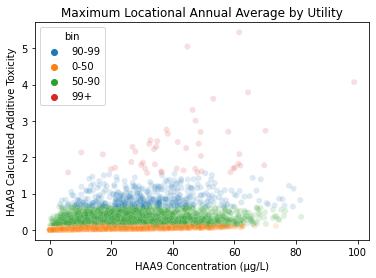

In [335]:
# Map violation data onto the results
g = sns.scatterplot(data=df_max_laa_haa9_2, x='Max LAA Concentration (µg/L)', y='Max LAA CAT', alpha=0.15, hue='bin')
g.set(title='Maximum Locational Annual Average by Utility')
g.set(xlabel='HAA9 Concentration (µg/L)', ylabel='HAA9 Calculated Additive Toxicity')

In [336]:
df_frac_cluster = df_max_laa_haa9_2['cluster'].value_counts() / df_max_laa_haa9_2['cluster'].count()
df_frac_cluster

0    0.500105
1    0.399831
2    0.089952
3    0.010112
Name: cluster, dtype: float64

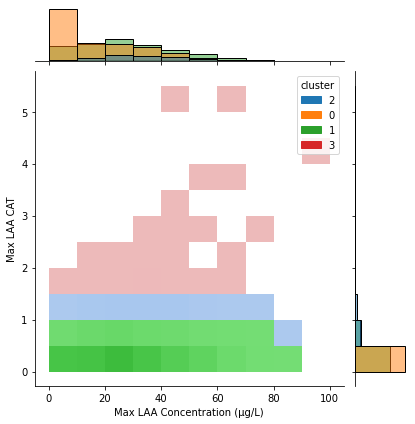

In [337]:
# Plot clusters
g = sns.jointplot(data=df_max_laa_haa9_2, x=conc_name, y=cti_name, hue='cluster', kind="hist", binwidth=(10, 0.5))


<AxesSubplot:xlabel='cluster', ylabel='Max LAA CAT'>

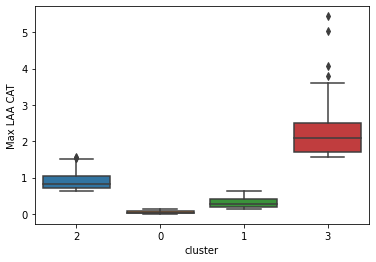

In [338]:
sns.boxplot(data=df_max_laa_haa9_2, y=cti_name, x='cluster')

<AxesSubplot:xlabel='cluster', ylabel='Max LAA Concentration (µg/L)'>

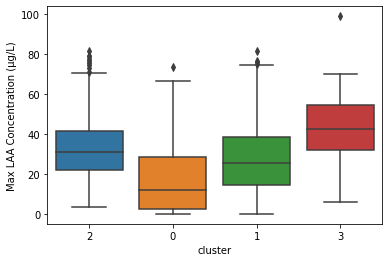

In [339]:
sns.boxplot(data=df_max_laa_haa9_2, y=conc_name, x='cluster')

### Investigate speciation of bins/clusters

In [340]:
# col_species = ['PWSID', 'Size', 'FacilityID', 'FacilityWaterType', 'SamplePointID', 'SampleEventCode', 'Contaminant', 'CalculatedResultValue(µg/L)']
# index_cols = ['PWSID', 'Size', 'FacilityID', 'FacilityWaterType', 'SamplePointID']
df_species_prep = pd.read_csv(path_haa_species_occur)
df_species_prep['FacilityID'] = df_species_prep['FacilityID'].apply(str)

In [341]:
# Add DBP abbreviations to the dataset
df_species_prep['Abbreviation'] = df_species_prep['Contaminant'].map(haa_dict)
df_species_prep = df_species_prep.drop(columns='Contaminant')


In [342]:
# Read in molecular weight and toxicity values (1/LC50)
dim_cols = ['MolecularWeight(g/mol)', '1/LC50(L/mol)', 'Abbreviation']
df_dim = pd.read_csv(path_dim)[dim_cols]
df_species = pd.merge(left=df_species_prep, right=df_dim, on='Abbreviation')

In [343]:
# Calculate CAT for each compound
# source: Allen et al. (2022) for CAT definition (DOI: 10.1021/acs.est.1c07998)
# required columns: CalculatedResultValue(µg/L), MolecularWeight(g/mol), 1/LC50(L/mol)
df_species['CAT'] = df_species.apply(lambda x: x['CalculatedResultValue(µg/L)'] / (x['MolecularWeight(g/mol)'] * 10**6) * x['1/LC50(L/mol)'] * 10**3, axis=1)

In [344]:
df_species.columns

Index(['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName',
       'FacilityWaterType', 'SamplePointID', 'SamplePointName',
       'SamplePointType', 'CollectionDate', 'SampleID', 'MRL', 'MethodID',
       'AnalyticalResultsSign', 'AnalyticalResultValue(µg/L)',
       'SampleEventCode', 'MonitoringRequirement', 'Region', 'State',
       'Abbreviation', 'CalculatedResultValue(µg/L)', 'MolecularWeight(g/mol)',
       '1/LC50(L/mol)', 'CAT'],
      dtype='object')

In [345]:
# Convert to wide format
df_species_w = df_species.pivot(index=['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode'], columns='Abbreviation', values='CAT').reset_index()

# Get locational annual average for each species
df_laa_species_w = df_species_w.groupby(['PWSID', 'FacilityID', 'SamplePointID'], as_index=False).mean()

In [346]:
# Subset data to get LAA for each species associated with the HAA9 maximum LAA sampling location
df_mlaa_haa9_spec = pd.merge(left=df_mlaa_haa9, right=df_laa_species_w, on=['PWSID', 'FacilityID', 'SamplePointID'], how='left')

# Add CAT data and cluster information
cluster_cols = ['PWSID', 'Max LAA CAT', 'cluster']
df_mlaa_haa9_spec_c = pd.merge(left=df_mlaa_haa9_spec, right=df_max_laa_haa9_2[cluster_cols], on=['PWSID'], how='left').dropna()  # drop values with no clusters

In [347]:
df_mlaa_haa9_spec_c

,PWSID,FacilityID,SamplePointID,Max LAA HAA9 (ug/L),BCAA,BDCAA,CDBAA,DBAA,DCAA,MBAA,MCAA,TBAA,TCAA,Max LAA CAT,cluster
0,010106001,1,D6,43.17250,0.034863,0.063474,0.059258,0.018446,0.006661,0.136578,0.013818,0.011430,0.007967,0.817932,2
1,010109005,4,SC4,59.81400,0.016309,0.019037,0.005906,0.000655,0.015028,0.000000,0.020956,0.000000,0.021263,0.099703,0
2,055293201,67890,DS1,4.88050,0.006736,0.000000,0.011287,0.016382,0.000173,0.166202,0.000000,0.006398,0.000000,0.207178,1
3,055294214,30001,DS2,0.65000,0.001664,0.000000,0.000000,0.000000,0.000351,0.000000,0.000000,0.000000,0.000000,0.002015,0
4,055294506,99001,DS001,1.58700,0.003985,0.000000,0.000000,0.001276,0.000741,0.000000,0.000000,0.000000,0.000000,0.006002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919,WY5600150,90001,S2PBLCWRKS,58.57750,0.037118,0.055298,0.017302,0.003988,0.013743,0.135423,0.000000,0.000000,0.016884,0.279757,1
4920,WY5600847,30001,DS1,45.70750,0.030131,0.039922,0.021157,0.005054,0.011342,0.184668,0.015557,0.000000,0.011676,0.319507,1
4921,WY5601181,1181,DBPR2,22.29575,0.019655,0.019377,0.013506,0.005765,0.007432,0.333173,0.000000,0.000000,0.003728,0.402637,1
4922,WY5601182,13659,S2WYBVRGE,34.84000,0.020888,0.021269,0.010950,0.003685,0.009690,0.000000,0.014337,0.000000,0.009264,0.125164,1


In [348]:
# Statistics for HAA CAT by species for cluster 2
df_mlaa_haa9_spec_c[df_mlaa_haa9_spec_c['cluster'] == '2'].describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.2f}'.format)

,Max LAA HAA9 (ug/L),BCAA,BDCAA,CDBAA,DBAA,DCAA,MBAA,MCAA,TBAA,TCAA,Max LAA CAT
count,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00
mean,32.48,0.04,0.03,0.05,0.03,0.01,0.61,0.01,0.01,0.00,0.89
std,15.16,0.02,0.02,0.04,0.03,0.01,0.27,0.03,0.01,0.00,0.22
min,3.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64
50%,31.11,0.04,0.02,0.03,0.03,0.01,0.60,0.00,0.00,0.00,0.82
90%,51.90,0.07,0.05,0.10,0.06,0.01,0.96,0.04,0.02,0.01,1.21
95%,58.97,0.08,0.06,0.11,0.08,0.02,1.08,0.07,0.03,0.01,1.36
97%,66.19,0.09,0.08,0.13,0.08,0.02,1.12,0.09,0.04,0.01,1.40
98%,70.70,0.09,0.09,0.13,0.10,0.02,1.17,0.11,0.05,0.01,1.44
99%,76.11,0.10,0.11,0.15,0.12,0.02,1.28,0.14,0.07,0.02,1.50


In [349]:
# Statistics for HAA CAT by species for cluster 3
df_mlaa_haa9_spec_c[df_mlaa_haa9_spec_c['cluster'] == '3'].describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.2f}'.format)

,Max LAA HAA9 (ug/L),BCAA,BDCAA,CDBAA,DBAA,DCAA,MBAA,MCAA,TBAA,TCAA,Max LAA CAT
count,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00
mean,43.09,0.05,0.03,0.05,0.05,0.01,1.53,0.03,0.01,0.00,2.31
std,17.21,0.03,0.02,0.05,0.06,0.01,1.06,0.06,0.02,0.00,0.87
min,5.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.57
50%,42.52,0.04,0.02,0.03,0.03,0.01,1.38,0.01,0.00,0.00,2.08
90%,61.69,0.09,0.05,0.11,0.12,0.02,2.66,0.07,0.02,0.01,3.40
95%,67.84,0.11,0.05,0.16,0.13,0.02,3.32,0.11,0.04,0.01,3.97
97%,69.94,0.12,0.07,0.20,0.16,0.02,4.29,0.12,0.06,0.01,4.65
98%,71.84,0.12,0.09,0.22,0.18,0.02,4.93,0.15,0.07,0.02,5.07
99%,85.36,0.13,0.10,0.22,0.23,0.03,4.99,0.24,0.07,0.02,5.26


In [350]:
# Calculate mass fractions for each HAA (normalized from 0 to 1)
df_mlaa_haa9_spec_c["BCAA_norm"] =  df_mlaa_haa9_spec_c["BCAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["BDCAA_norm"] = df_mlaa_haa9_spec_c["BDCAA"] / df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["CDBAA_norm"] = df_mlaa_haa9_spec_c["CDBAA"] / df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["DBAA_norm"] =  df_mlaa_haa9_spec_c["DBAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["DCAA_norm"] =  df_mlaa_haa9_spec_c["DCAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["MBAA_norm"] =  df_mlaa_haa9_spec_c["MBAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["MCAA_norm"] =  df_mlaa_haa9_spec_c["MCAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["TBAA_norm"] =  df_mlaa_haa9_spec_c["TBAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']
df_mlaa_haa9_spec_c["TCAA_norm"] =  df_mlaa_haa9_spec_c["BCAA"] /  df_mlaa_haa9_spec_c['Max LAA CAT']

df_mlaa_haa9_spec_c = df_mlaa_haa9_spec_c.drop(columns=['BCAA','BDCAA','CDBAA','DBAA','DCAA','MBAA','MCAA','TBAA','TCAA'])
# df_mlaa_haa9_spec_c = df_mlaa_haa9_spec_c.drop(columns=['BCAA','BDCAA','CDBAA','DBAA','DCAA','TBAA','TCAA'])

In [351]:
# Statistics for HAA species for cluster 2
df_mlaa_haa9_spec_c[df_mlaa_haa9_spec_c['cluster'] == '2'].describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.2f}'.format)

,Max LAA HAA9 (ug/L),Max LAA CAT,BCAA_norm,BDCAA_norm,CDBAA_norm,DBAA_norm,DCAA_norm,MBAA_norm,MCAA_norm,TBAA_norm,TCAA_norm
count,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00,427.00
mean,32.48,0.89,0.05,0.03,0.05,0.04,0.01,0.68,0.01,0.01,0.05
std,15.16,0.22,0.02,0.03,0.04,0.03,0.01,0.23,0.03,0.01,0.02
min,3.35,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,31.11,0.82,0.04,0.03,0.04,0.03,0.01,0.74,0.00,0.00,0.04
90%,51.90,1.21,0.08,0.06,0.11,0.07,0.02,0.90,0.05,0.02,0.08
95%,58.97,1.36,0.09,0.07,0.13,0.08,0.02,0.93,0.07,0.03,0.09
97%,66.19,1.40,0.10,0.09,0.14,0.08,0.03,0.94,0.09,0.04,0.10
98%,70.70,1.44,0.10,0.11,0.15,0.09,0.03,0.95,0.10,0.05,0.10
99%,76.11,1.50,0.10,0.13,0.18,0.11,0.03,0.95,0.13,0.06,0.10


In [352]:
# Statistics for HAA species for cluster 3
df_mlaa_haa9_spec_c[df_mlaa_haa9_spec_c['cluster'] == '3'].describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.2f}'.format)

,Max LAA HAA9 (ug/L),Max LAA CAT,BCAA_norm,BDCAA_norm,CDBAA_norm,DBAA_norm,DCAA_norm,MBAA_norm,MCAA_norm,TBAA_norm,TCAA_norm
count,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00,48.00
mean,43.09,2.31,0.02,0.01,0.02,0.02,0.00,0.66,0.01,0.00,0.02
std,17.21,0.87,0.02,0.01,0.02,0.02,0.00,0.31,0.03,0.01,0.02
min,5.96,1.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,42.52,2.08,0.02,0.01,0.02,0.01,0.00,0.81,0.00,0.00,0.02
90%,61.69,3.40,0.04,0.02,0.05,0.07,0.01,0.95,0.04,0.01,0.04
95%,67.84,3.97,0.06,0.03,0.05,0.07,0.01,0.97,0.06,0.02,0.06
97%,69.94,4.65,0.07,0.03,0.07,0.07,0.01,0.98,0.07,0.02,0.07
98%,71.84,5.07,0.07,0.03,0.08,0.08,0.01,0.98,0.09,0.02,0.07
99%,85.36,5.26,0.07,0.05,0.11,0.08,0.01,0.98,0.14,0.03,0.07


In [353]:
# Convert data into tall format
# val_vars = ['BCAA_norm', 'BDCAA_norm', 'CDBAA_norm', 'DBAA_norm', 'DCAA_norm', 'TBAA_norm', 'TCAA_norm']
val_vars = ['BCAA_norm', 'BDCAA_norm', 'CDBAA_norm', 'DBAA_norm', 'DCAA_norm', 'MBAA_norm', 'MCAA_norm', 'TBAA_norm', 'TCAA_norm']
index_idx = ~df_mlaa_haa9_spec_c.columns.isin(val_vars)
index_vars = df_mlaa_haa9_spec_c.columns[index_idx]
df_mlaa_haa9_spec_c_t = pd.melt(df_mlaa_haa9_spec_c, id_vars=index_vars, value_vars=val_vars, var_name='Abbreviation', value_name='Fraction of Max LAA HAA9 CAT')

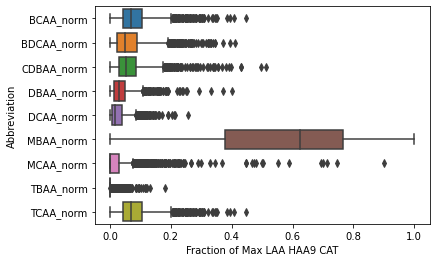

In [354]:
# Compare concentrations of HAAs for each cluster
# order=["DCAA", "BCAA", "MCAA", "TBAA", "TCAA", "DBAA", "BDCAA", "CDBAA", "MBAA"]
g = sns.boxplot(data=df_mlaa_haa9_spec_c_t[df_mlaa_haa9_spec_c_t['cluster'] != '0'], x='Fraction of Max LAA HAA9 CAT', y='Abbreviation')
# g.set_xscale("log")

In [355]:
df_mlaa_haa9_spec_c_t[df_mlaa_haa9_spec_c_t['cluster'] == '2']

,PWSID,FacilityID,SamplePointID,Max LAA HAA9 (ug/L),Max LAA CAT,cluster,Abbreviation,Fraction of Max LAA HAA9 CAT
0,010106001,1,D6,43.17250,0.817932,2,BCAA_norm,0.042623
61,AL0000314,99001,DS001,52.78250,0.942683,2,BCAA_norm,0.039806
99,AL0000804,805,3,46.96500,0.699159,2,BCAA_norm,0.031991
109,AL0000908,99001,DS002,16.06500,1.233199,2,BCAA_norm,0.009623
118,AL0001002,99001,DS002,51.98800,0.689711,2,BCAA_norm,0.084370
...,...,...,...,...,...,...,...,...
42644,WI4360364,18,D26,35.46725,0.643212,2,TCAA_norm,0.050172
42645,WI4360436,83,D1,35.53350,0.765454,2,TCAA_norm,0.049086
42679,WV3300516,99001,S2THM1,52.68925,1.507799,2,TCAA_norm,0.021107
42689,WV3302364,99001,S2DBP1,26.67750,0.894817,2,TCAA_norm,0.028446


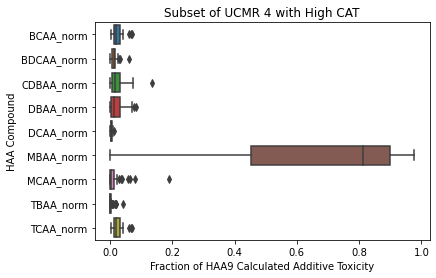

In [356]:
# Compare concentrations of HAAs for each cluster
plt.figure()
g = sns.boxplot(data=df_mlaa_haa9_spec_c_t[df_mlaa_haa9_spec_c_t['cluster'] == '3'], x='Fraction of Max LAA HAA9 CAT', y='Abbreviation')
g.set(title='Subset of UCMR 4 with High CAT')
g.set(xlabel='Fraction of HAA9 Calculated Additive Toxicity', ylabel='HAA Compound')
plt.savefig('HAA9_frac-cat-by-HAA.png', dpi=900) # Save that figure

In [357]:
# Export data
# df_mlaa_haa9_spec_c_t[df_mlaa_haa9_spec_c_t['cluster'] == '3'].to_csv(r"C:\Users\WRaseman\OneDrive - Hazen and Sawyer\Projects - Active\70063-000 WRF 5085 HAA\Marketing\HAA9_frac_boxplot.csv")

### Investigate MBAA, treatment technologies, disinfectant type, source water quality, and geography of green vs. orange cluster

In [358]:
# # Get PWSIDs for green (2) and orange (3) clusters
# df_clust23_pid = df_clust_mlaa_haa9[df_clust_mlaa_haa9['cluster'].isin(['0', '2', '3'])][['PWSID', 'cluster']]

# Get PWSIDs for utilities included in the binning
df_pid = df_max_laa_haa9_2[['PWSID', 'cluster']]
df_pid


,PWSID,cluster
0,010106001,2
1,010109005,0
2,055293201,1
3,055294214,0
4,055294506,0
...,...,...
4919,WY5600150,1
4920,WY5600847,1
4921,WY5601181,1
4922,WY5601182,1


In [359]:
# Source water quality and treatment data
# source: https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
df_td = pd.read_csv(path_trt_dis, sep='\t', encoding = "ISO-8859-1")
df_td['FacilityID'] = df_td['FacilityID'].apply(str)
df_swq = pd.read_csv(path_source_wq, sep='\t', encoding = "ISO-8859-1")
df_swq['FacilityID'] = df_swq['FacilityID'].apply(str)

C:\Users\WRaseman\AppData\Local\Temp\ipykernel_22492\3103384653.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_td = pd.read_csv(path_trt_dis, sep='\t', encoding = "ISO-8859-1")


#### Source water quality

In [360]:
# Set value for non-detects based on user input (see top of notebook for that value)
df_swq["CalculatedResultValue(µg/L)"] = df_swq.apply(
    lambda x:  value_belowMRL if x["AnalyticalResultsSign"] == '<' else x["AnalyticalResultValue(µg/L)"], axis=1)

df_swq2 = df_swq[['PWSID', 'FacilityID', 'SamplePointID', 'Contaminant', 'SampleEventCode', 'CalculatedResultValue(µg/L)']]
df_swq2.head()

,PWSID,FacilityID,SamplePointID,Contaminant,SampleEventCode,CalculatedResultValue(µg/L)
0,010106001,7,RAW1,bromide,SEH1,157.0
1,010106001,7,RAW1,total organic carbon,SEH1,3110.0
2,010106001,7,RAW1,bromide,SEH2,117.0
3,010106001,7,RAW1,total organic carbon,SEH2,2670.0
4,010106001,7,RAW1,bromide,SEH3,134.0


In [361]:
# Make data wide and add units to bromide and TOC
df_swq_wide = df_swq2.pivot_table(index=['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode'], 
    columns='Contaminant', values='CalculatedResultValue(µg/L)', aggfunc='mean').reset_index()
df_swq_wide['TOC(mg/L)'] = df_swq_wide['total organic carbon'] / 1000
df_swq_wide = df_swq_wide.rename(columns={'bromide': 'Bromide(µg/L)'})

In [362]:
# Calculate Br:TOC ratio
df_swq_wide['Br_TOC_Ratio'] = df_swq_wide['Bromide(µg/L)'].divide(df_swq_wide['TOC(mg/L)'])  # ug/L Br / mg/L TOC
df_swq_wide.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace infs with NaN

In [363]:
# Add cluster information to source water quality data
df_swq_sa = pd.merge(left=df_swq_wide, right=df_pid, on='PWSID')
df_swq_sa.head()

,PWSID,FacilityID,SamplePointID,SampleEventCode,Bromide(µg/L),total organic carbon,TOC(mg/L),Br_TOC_Ratio,cluster
0,010106001,7,RAW1,SEH1,157.0,3110.0,3.11,50.482315,2
1,010106001,7,RAW1,SEH2,117.0,2670.0,2.67,43.820225,2
2,010106001,7,RAW1,SEH3,134.0,3730.0,3.73,35.924933,2
3,010106001,7,RAW1,SEH4,214.0,3370.0,3.37,63.501484,2
4,010106001,8,RAW2,SEH1,908.0,0.0,0.00,NaN,2


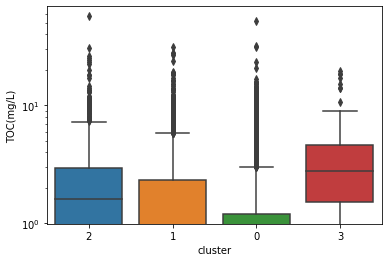

In [364]:
g=sns.boxplot(data=df_swq_sa, x='cluster', y='TOC(mg/L)')
g.set_yscale("log")

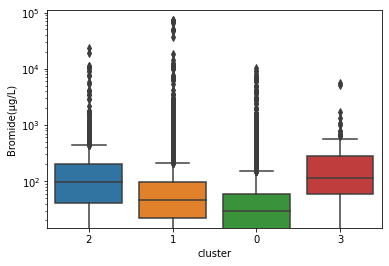

In [365]:
g = sns.boxplot(data=df_swq_sa, x='cluster', y='Bromide(µg/L)')
g.set_yscale("log")

In [366]:
# Count number of non-detect bromide for cluster 0
frac_br_nd_0 = len(df_swq_sa[(df_swq_sa['Bromide(µg/L)'] == 0) & (df_swq_sa['cluster'] == '0')].index)/len(df_swq_sa[df_swq_sa['cluster'] == '0'].index)
print(f"There are {frac_br_nd_0*100:.1f}% non-detects for source water bromide for PWSIDs in cluster 0 (blue).")

There are 35.9% non-detects for source water bromide for PWSIDs in cluster 0 (blue).


In [367]:
# Count number of non-detect bromide for cluster 2
frac_br_nd_2 = len(df_swq_sa[(df_swq_sa['Bromide(µg/L)'] == 0) & (df_swq_sa['cluster'] == '2')].index)/len(df_swq_sa[df_swq_sa['cluster'] == '2'].index)
print(f"There are {frac_br_nd_2*100:.1f}% non-detects for source water bromide for PWSIDs in cluster 2 (orange).")

There are 12.6% non-detects for source water bromide for PWSIDs in cluster 2 (orange).


In [368]:
# Count number of non-detect bromide for cluster 3
frac_br_nd_3 = len(df_swq_sa[(df_swq_sa['Bromide(µg/L)'] == 0) & (df_swq_sa['cluster'] == '3')].index)/len(df_swq_sa[df_swq_sa['cluster'] == '3'].index)
print(f"There are {frac_br_nd_3*100:.1f}% non-detects for source water bromide for PWSIDs in cluster 3 (green).")

There are 9.2% non-detects for source water bromide for PWSIDs in cluster 3 (green).


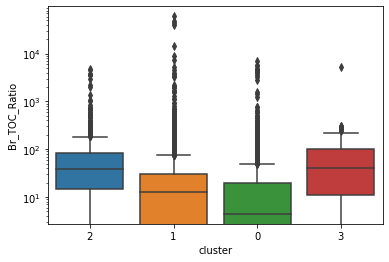

In [369]:
g=sns.boxplot(data=df_swq_sa, x='cluster', y='Br_TOC_Ratio')
g.set_yscale("log")

#### Treatment and disinfectant type

In [370]:
# Get counts of PWSIDs
trt_total_pwsid = len(df_td['PWSID'].unique())
trt_c0_pwsid = len(df_pid[df_pid['cluster']=='0']['PWSID'].unique())
trt_c1_pwsid = len(df_pid[df_pid['cluster']=='1']['PWSID'].unique())
trt_c2_pwsid = len(df_pid[df_pid['cluster']=='2']['PWSID'].unique())
trt_c3_pwsid = len(df_pid[df_pid['cluster']=='3']['PWSID'].unique())

print(f"Number of PWSIDs w/treatment or disinfectant info: {trt_c0_pwsid} out of {trt_total_pwsid} PWSIDs are in cluster 0, or {trt_c0_pwsid/trt_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {trt_c1_pwsid} out of {trt_total_pwsid} PWSIDs are in cluster 1, or {trt_c1_pwsid/trt_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {trt_c2_pwsid} out of {trt_total_pwsid} PWSIDs are in cluster 2, or {trt_c2_pwsid/trt_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {trt_c3_pwsid} out of {trt_total_pwsid} PWSIDs are in cluster 3, or {trt_c3_pwsid/trt_total_pwsid*100:.1f}%")


Number of PWSIDs w/treatment or disinfectant info: 2374 out of 4532 PWSIDs are in cluster 0, or 52.4%
Number of PWSIDs w/treatment or disinfectant info: 1898 out of 4532 PWSIDs are in cluster 1, or 41.9%
Number of PWSIDs w/treatment or disinfectant info: 427 out of 4532 PWSIDs are in cluster 2, or 9.4%
Number of PWSIDs w/treatment or disinfectant info: 48 out of 4532 PWSIDs are in cluster 3, or 1.1%


In [371]:
# Add cluster information to treatment and disinfection data
df_td_sa = pd.merge(left=df_td, right=df_pid, on='PWSID')
df_trt_sa = df_td_sa[df_td_sa['AdditionalDataElement'] == 'TreatmentInformation']
df_trt_sa = df_trt_sa[df_trt_sa['Response'].isin(trt_tech)]  # only look at a subset of treatment technologies
df_trt_sa_grp = df_trt_sa.groupby(['PWSID', 'Response']).last().reset_index()  # compile a list of all unique treatment responses for each PWSID

In [372]:
df_trt_sa_grp

,PWSID,Response,FacilityID,SamplePointID,SampleEventCode,AdditionalDataElement,IfOtherText,cluster
0,010106001,GAC,1,D19,SEH4,TreatmentInformation,None,2
1,090400090,GAC,30001,DS2,SEH4,TreatmentInformation,None,3
2,090400109,IEX,1,DBP02,SEH2,TreatmentInformation,None,0
3,AL0000327,GAC,9001,DS004,SEH4,TreatmentInformation,None,1
4,AL0000413,GAC,12345,DSO2,SEH4,TreatmentInformation,None,1
...,...,...,...,...,...,...,...,...
475,WI7500094,IEX,30001,DS2,SEH2,TreatmentInformation,None,0
476,WI7500726,IEX,99003,MR003,SEH2,TreatmentInformation,None,1
477,WV3302016,GAC,99001,S2THM4,SEH4,TreatmentInformation,None,1
478,WV3302104,GAC,99001,S2THM2,SEH4,TreatmentInformation,None,0


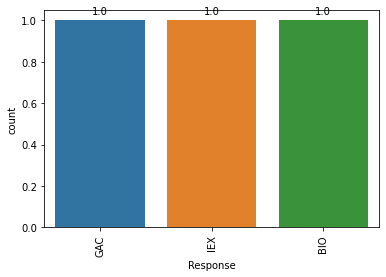

In [373]:
# Treatment technologies for a given cluster

# df_trt_sa_grp

# grid = sns.FacetGrid(data=df_trt_sa_grp,col='cluster')
# g = grid.map(sns.countplot, 'Response')

g = sns.countplot(data = df_trt_sa_grp[df_trt_sa_grp['cluster'] == '3'], x="Response")
g.tick_params(axis='x', rotation=90)


# Add numbers to bars
# source: https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


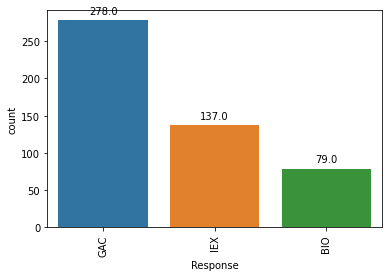

In [374]:
# Treatment technologies for entire dataset
df_td_trt = df_td[df_td['Response'].isin(trt_tech)]  # only look at a subset of treatment technologies
df_td_trt_grp = df_td_trt.groupby(['PWSID', 'Response']).last().reset_index()  # GAC, IEX, and BAF do not vary in time, so choose any entry as representative of the PWSID
g = sns.countplot(data = df_td_trt_grp[df_td_trt_grp['AdditionalDataElement'] == 'TreatmentInformation'], x="Response")
g.tick_params(axis='x', rotation=90)

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# GAC: 270/4532=6%, BIO: 137/4532=3%, IEX: 79/4532=<2%

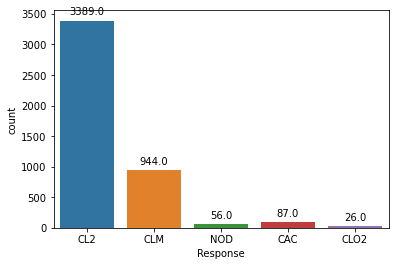

In [375]:
# Disinfectant residual (all data)
df_dis = df_td[(df_td['AdditionalDataElement'] == 'DisinfectantResidual') | (df_td['AdditionalDataElement'] == 'DisinfectantType')]
df_dis_grp = df_dis.groupby(['PWSID', 'AdditionalDataElement']).last().reset_index()  # compile a list of all unique treatment responses for each PWSID
g=sns.countplot(data = df_dis_grp[df_dis_grp['AdditionalDataElement'] == 'DisinfectantResidual'], x="Response")

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [376]:
# Get counts of observations and join disinfectant data with cluster information
dis_total_pwsid = len(df_dis_grp['PWSID'].unique())  # get number of PWSIDs with disinfectant or disinfectant residual type data

df_dis_sa = pd.merge(left=df_dis_grp, right=df_pid, on='PWSID')
dis_c0_pwsid = len(df_dis_sa[df_dis_sa['cluster']=='0']['PWSID'].unique())
dis_c1_pwsid = len(df_dis_sa[df_dis_sa['cluster']=='1']['PWSID'].unique())
dis_c2_pwsid = len(df_dis_sa[df_dis_sa['cluster']=='2']['PWSID'].unique())
dis_c3_pwsid = len(df_dis_sa[df_dis_sa['cluster']=='3']['PWSID'].unique())

print(f"Number of PWSIDs w/treatment or disinfectant info: {dis_c0_pwsid} out of {dis_total_pwsid} PWSIDs are in cluster 0, or {dis_c0_pwsid/dis_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {dis_c1_pwsid} out of {dis_total_pwsid} PWSIDs are in cluster 1, or {dis_c1_pwsid/dis_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {dis_c2_pwsid} out of {dis_total_pwsid} PWSIDs are in cluster 2, or {dis_c2_pwsid/dis_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/treatment or disinfectant info: {dis_c3_pwsid} out of {dis_total_pwsid} PWSIDs are in cluster 3, or {dis_c3_pwsid/dis_total_pwsid*100:.1f}%")


Number of PWSIDs w/treatment or disinfectant info: 2193 out of 4528 PWSIDs are in cluster 0, or 48.4%
Number of PWSIDs w/treatment or disinfectant info: 1736 out of 4528 PWSIDs are in cluster 1, or 38.3%
Number of PWSIDs w/treatment or disinfectant info: 392 out of 4528 PWSIDs are in cluster 2, or 8.7%
Number of PWSIDs w/treatment or disinfectant info: 46 out of 4528 PWSIDs are in cluster 3, or 1.0%


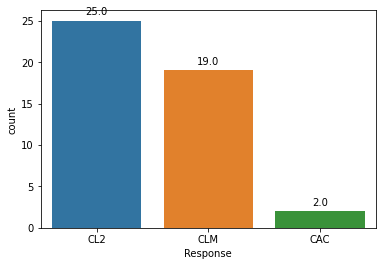

In [377]:
# Disinfectant residual type for a cluster
df_dis_sa_c0 = df_dis_sa[df_dis_sa['cluster']=='3']
g=sns.countplot(data = df_dis_sa_c0[df_dis_sa_c0['AdditionalDataElement'] == 'DisinfectantResidual'], x="Response")

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Source water type

In [378]:
df_swtype = pd.merge(left=df_species_prep, right=df_pid, on='PWSID')

In [379]:
swtype_cols = ['PWSID', 'FacilityWaterType', 'cluster']
df_swtype_c = df_swtype[swtype_cols].drop_duplicates()
df_swtype_c

,PWSID,FacilityWaterType,cluster
0,010106001,GU,2
144,010109005,SW,0
288,055293201,GW,1
324,055294214,GW,0
360,055294506,GW,0
...,...,...,...
543510,WY5600150,SW,1
543654,WY5600847,SW,1
543690,WY5601181,SW,1
543762,WY5601182,SW,1


In [380]:
# Get counts for each cluster
swtype_total_pwsid = len(df_swtype_c.index)
swtype_c0_pwsid = len(df_swtype_c[df_swtype_c['cluster']=='0'].index)
swtype_c1_pwsid = len(df_swtype_c[df_swtype_c['cluster']=='1'].index)
swtype_c2_pwsid = len(df_swtype_c[df_swtype_c['cluster']=='2'].index)
swtype_c3_pwsid = len(df_swtype_c[df_swtype_c['cluster']=='3'].index)

In [381]:
print(f"Number of PWSIDs w/source water type: {swtype_c0_pwsid} out of {swtype_total_pwsid} PWSIDs are in cluster 0, or {swtype_c0_pwsid/swtype_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/source water type: {swtype_c1_pwsid} out of {swtype_total_pwsid} PWSIDs are in cluster 1, or {swtype_c1_pwsid/swtype_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/source water type: {swtype_c2_pwsid} out of {swtype_total_pwsid} PWSIDs are in cluster 2, or {swtype_c2_pwsid/swtype_total_pwsid*100:.1f}%")
print(f"Number of PWSIDs w/source water type: {swtype_c3_pwsid} out of {swtype_total_pwsid} PWSIDs are in cluster 3, or {swtype_c3_pwsid/swtype_total_pwsid*100:.1f}%")

Number of PWSIDs w/source water type: 2405 out of 4834 PWSIDs are in cluster 0, or 49.8%
Number of PWSIDs w/source water type: 1938 out of 4834 PWSIDs are in cluster 1, or 40.1%
Number of PWSIDs w/source water type: 443 out of 4834 PWSIDs are in cluster 2, or 9.2%
Number of PWSIDs w/source water type: 48 out of 4834 PWSIDs are in cluster 3, or 1.0%


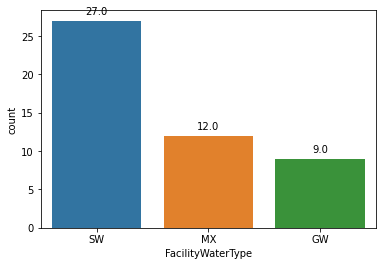

In [382]:
# Source water type for a cluster
df_swtype_c0 = df_swtype_c[df_swtype_c['cluster']=='3']
g=sns.countplot(data = df_swtype_c0, x="FacilityWaterType")

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# n = 1281

## Adv treatment, SW impairment, and disinfectant residual categories
Source water and treatment matrix:
- 2 source water categories
    - Impaired (TOC and Br above a threshold)
    - Not impaired
- 4 treatment categories
    - Advanced Treatment + Chlorine
    - Advanced Treatment + Chloramines
    - No Advanced Treatment + Chlorine
    - No Advanced Treatment + Chloramines

Advanced treatment is defined as GAC, ion exchange, or biological filtration (BAF).


### Calculate the categories

In [383]:
# Create source water categories
df_swq_grp = df_swq_wide.groupby('PWSID').agg({'Bromide(µg/L)':'mean', 'TOC(mg/L)':'mean'}).reset_index()

## Set the source water thresholds
bromide_thresh = 100  # ug/L
toc_thresh = 2  # mg/L
df_swq_grp['Impaired Source'] = df_swq_grp.apply(lambda x: True 
    if x['Bromide(µg/L)'] > bromide_thresh and x['TOC(mg/L)'] > toc_thresh else False, axis=1)
display(df_swq_grp)
display(df_swq_grp.value_counts('Impaired Source'))

Contaminant,PWSID,Bromide(µg/L),TOC(mg/L),Impaired Source
0,010106001,519.0000,1.6100,False
1,055293201,56.2500,0.5200,False
2,055294214,10.0000,0.0000,False
3,055294506,27.6125,0.0000,False
4,063500120,260.0000,0.0000,False
...,...,...,...,...
3434,WY5600047,0.0000,2.3440,False
3435,WY5600052,0.0000,2.4125,False
3436,WY5600053,290.0000,0.0000,False
3437,WY5600150,7.3500,3.3300,False


Impaired Source
False    3217
True      222
dtype: int64

In [384]:
df_swq_grp.describe(percentiles=[0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]).applymap('{:,.1f}'.format)

Contaminant,Bromide(µg/L),TOC(mg/L)
count,"3,438.0","3,433.0"
mean,152.4,1.8
std,"1,305.7",2.2
min,0.0,0.0
50%,34.5,1.1
90%,183.5,4.7
95%,354.0,6.0
97%,500.0,6.9
98%,694.0,7.8
99%,"1,863.7",9.8


In [385]:
# Create treatment categories (PWSID, Trt_GAC, Trt_Ion Exchange, Trt_Biofiltration, Trt_Category, Disinfection, Disinfection_Category)
df_advtrt = df_td_sa[df_td_sa['AdditionalDataElement'] == 'TreatmentInformation']
df_advtrt['Adv Treatment'] = df_advtrt.apply(lambda x: True 
    if (x['Response'] == 'GAC') | (x['Response'] == 'IEX') | (x['Response'] == 'BAF') else False, axis=1)
display(df_advtrt.value_counts('Adv Treatment'))
display(df_advtrt)

## Assign one advanced treatment category to each PWSID (only 1 PWSID per row)
df_advtrt_grp = df_advtrt.groupby('PWSID').apply(lambda x: 
    x['Adv Treatment'].any()).reset_index(name='Adv Treatment')
display(df_advtrt_grp)
display(df_advtrt_grp.value_counts('Adv Treatment'))

C:\Users\WRaseman\AppData\Local\Temp\ipykernel_22492\2805447478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_advtrt['Adv Treatment'] = df_advtrt.apply(lambda x: True


Adv Treatment
False    105750
True       4941
dtype: int64

,PWSID,FacilityID,SamplePointID,SampleEventCode,AdditionalDataElement,Response,IfOtherText,cluster,Adv Treatment
1,010106001,1,D12,SEH1,TreatmentInformation,MFL,NaN,2,False
2,010106001,1,D12,SEH1,TreatmentInformation,GWD,NaN,2,False
3,010106001,1,D12,SEH1,TreatmentInformation,GAC,NaN,2,True
5,010106001,1,D12,SEH2,TreatmentInformation,MFL,NaN,2,False
6,010106001,1,D12,SEH2,TreatmentInformation,GWD,NaN,2,False
...,...,...,...,...,...,...,...,...,...
250583,WY5601415,90002,DIS002,SEH3,TreatmentInformation,RBF,NaN,0,False
250584,WY5601415,90002,DIS002,SEH3,TreatmentInformation,CON,NaN,0,False
250588,WY5601415,90002,DIS002,SEH4,TreatmentInformation,GWD,NaN,0,False
250589,WY5601415,90002,DIS002,SEH4,TreatmentInformation,RBF,NaN,0,False


,PWSID,Adv Treatment
0,010106001,True
1,010109005,False
2,055293201,False
3,055294214,False
4,055294506,False
...,...,...
4323,WY5600150,False
4324,WY5600847,False
4325,WY5601181,False
4326,WY5601182,False


Adv Treatment
False    3948
True      380
dtype: int64

In [386]:
# Create category for whether the utility uses chloramines (any record with a CLM or CAC)
# - CLM = Chloramines (originating from the addition of chlorine and ammonia or pre-formed chloramines)
# - CAC = Chlorine and chloramines (if being mixed from chlorinated and chloraminated water)
df_disres = df_td[df_td['AdditionalDataElement'] == 'DisinfectantResidual'][['PWSID', 'Response']]
df_disres = df_disres.rename(columns={'Response':'DisinfectantResidual'})

## Identify all entries that are chloramines or mixed (chloramines and chlorine) systems
df_disres['Chloramines'] = False  # initialize values as False
df_disres['Chloramines'] = df_disres.apply(lambda x: True 
    if (x['DisinfectantResidual'] == 'CLM') | (x['DisinfectantResidual'] == 'CAC') else False, axis=1)
display(df_disres)
display(df_disres.value_counts('DisinfectantResidual'))

,PWSID,DisinfectantResidual,Chloramines
0,010106001,CL2,False
8,010106001,CL2,False
13,010106001,CL2,False
18,010106001,CL2,False
23,010106001,CL2,False
...,...,...,...
262637,WY5601415,CLM,True
262640,WY5601415,CLM,True
262644,WY5601415,CLM,True
262653,WY5601415,CLM,True


DisinfectantResidual
CL2     39523
CLM     17337
CAC      1554
NOD       460
CLO2      309
CLGA        2
CAGC        1
CLOF        1
dtype: int64

In [387]:
## Assign one chloramine category to each PWSID (only 1 PWSID per row)
df_disres_grp = df_disres.groupby('PWSID').apply(lambda x: 
    x['Chloramines'].any()).reset_index(name='Chloramines')
display(df_disres_grp)
display(df_disres_grp.value_counts('Chloramines'))

,PWSID,Chloramines
0,010106001,False
1,010109005,False
2,055293201,False
3,055294214,False
4,055294506,False
...,...,...
4497,WY5600150,False
4498,WY5600847,False
4499,WY5601181,False
4500,WY5601182,False


Chloramines
False    3427
True     1075
dtype: int64

In [388]:
# Get max LAA HAA9 by PWSID, CAT for HAA9 by PWSID (associated with max LAA HAA9), and Stage 2 Compliance category
include_violations = True  

if include_violations == True:
    # Include values with violations in the analysis
    df_haa_comp_grp = df_max_laa_haa9_3[['PWSID', 'Max LAA Concentration (µg/L)', 'Max LAA CAT', 'STG2_MCL']]
else:
    df_haa_comp_grp = df_max_laa_haa9_4[['PWSID', 'Max LAA Concentration (µg/L)', 'Max LAA CAT', 'STG2_MCL']]
    
display(df_haa_comp_grp)

,PWSID,Max LAA Concentration (µg/L),Max LAA CAT,STG2_MCL
0,010106001,43.17250,0.817932,Uncertain (No TTHM Data)
1,010109005,59.81400,0.099703,Uncertain (No TTHM Data)
2,055293201,4.88050,0.207178,Uncertain (No TTHM Data)
3,055294214,0.65000,0.002015,Uncertain (No TTHM Data)
4,055294506,1.58700,0.006002,Uncertain (No TTHM Data)
...,...,...,...,...
4919,WY5600150,58.57750,0.279757,No Violation
4920,WY5600847,45.70750,0.319507,No Violation
4921,WY5601181,22.29575,0.402637,No Violation
4922,WY5601182,34.84000,0.125164,No Violation


In [389]:
# Combine all dataframes with categorical variables into a single dataframe
df_merged = df_haa_comp_grp  # begin with HAAs as a template

## Step 1: combine HAA CAT and concentration with advanced treatment category
df_merged1 = pd.merge(df_merged, df_advtrt_grp, on='PWSID', how='left', validate='1:1')

## Step 2: add the disinfectant residual category
df_merged2 = pd.merge(df_merged1, df_disres_grp, on='PWSID', how='left', validate='1:1')

## Step 3: add the source water impairment category
df_merged3 = pd.merge(df_merged2, df_swq_grp, on='PWSID', how='left', validate='1:1')

display(df_merged3.columns)
display(df_merged3)
display(df_merged3.info())

Index(['PWSID', 'Max LAA Concentration (µg/L)', 'Max LAA CAT', 'STG2_MCL',
       'Adv Treatment', 'Chloramines', 'Bromide(µg/L)', 'TOC(mg/L)',
       'Impaired Source'],
      dtype='object')

,PWSID,Max LAA Concentration (µg/L),Max LAA CAT,STG2_MCL,Adv Treatment,Chloramines,Bromide(µg/L),TOC(mg/L),Impaired Source
0,010106001,43.17250,0.817932,Uncertain (No TTHM Data),True,False,519.0000,1.610,False
1,010109005,59.81400,0.099703,Uncertain (No TTHM Data),False,False,NaN,NaN,NaN
2,055293201,4.88050,0.207178,Uncertain (No TTHM Data),False,False,56.2500,0.520,False
3,055294214,0.65000,0.002015,Uncertain (No TTHM Data),False,False,10.0000,0.000,False
4,055294506,1.58700,0.006002,Uncertain (No TTHM Data),False,False,27.6125,0.000,False
...,...,...,...,...,...,...,...,...,...
4919,WY5600150,58.57750,0.279757,No Violation,False,False,7.3500,3.330,False
4920,WY5600847,45.70750,0.319507,No Violation,False,False,NaN,NaN,NaN
4921,WY5601181,22.29575,0.402637,No Violation,False,False,NaN,NaN,NaN
4922,WY5601182,34.84000,0.125164,No Violation,False,False,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4924 entries, 0 to 4923
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PWSID                         4924 non-null   object 
 1   Max LAA Concentration (µg/L)  4924 non-null   float64
 2   Max LAA CAT                   4924 non-null   float64
 3   STG2_MCL                      4924 non-null   object 
 4   Adv Treatment                 4328 non-null   object 
 5   Chloramines                   4498 non-null   object 
 6   Bromide(µg/L)                 3430 non-null   float64
 7   TOC(mg/L)                     3428 non-null   float64
 8   Impaired Source               3431 non-null   object 
dtypes: float64(4), object(5)
memory usage: 384.7+ KB


None

#### Add species data for CART analysis (by Eric)

In [390]:
## Step 4: add species level data
species_col = ['PWSID', 'BCAA','BDCAA','CDBAA','DBAA','DCAA','MBAA','MCAA','TBAA','TCAA']
df_cart = pd.merge(df_merged3, df_species_mlaa_w[species_col], on='PWSID', how='left', validate='1:1')
display(df_cart)

,PWSID,Max LAA Concentration (µg/L),Max LAA CAT,STG2_MCL,Adv Treatment,Chloramines,Bromide(µg/L),TOC(mg/L),Impaired Source,BCAA,BDCAA,CDBAA,DBAA,DCAA,MBAA,MCAA,TBAA,TCAA
0,010106001,43.17250,0.817932,Uncertain (No TTHM Data),True,False,519.0000,1.610,False,4.71500,9.10250,2.9900,2.19000,8.0600,0.1775,1.1325,1.84,12.96500
1,010109005,59.81400,0.099703,Uncertain (No TTHM Data),False,False,NaN,NaN,NaN,2.20575,2.73000,0.2980,0.07775,18.1850,0.0000,1.7175,0.00,34.60000
2,055293201,4.88050,0.207178,Uncertain (No TTHM Data),False,False,56.2500,0.520,False,0.91100,0.00000,0.5695,1.94500,0.2090,0.2160,0.0000,1.03,0.00000
3,055294214,0.65000,0.002015,Uncertain (No TTHM Data),False,False,10.0000,0.000,False,0.22500,0.00000,0.0000,0.00000,0.4250,0.0000,0.0000,0.00,0.00000
4,055294506,1.58700,0.006002,Uncertain (No TTHM Data),False,False,27.6125,0.000,False,0.53900,0.00000,0.0000,0.15150,0.8965,0.0000,0.0000,0.00,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919,WY5600150,58.57750,0.279757,No Violation,False,False,7.3500,3.330,False,5.02000,7.93000,0.8730,0.47350,16.6300,0.1760,0.0000,0.00,27.47500
4920,WY5600847,45.70750,0.319507,No Violation,False,False,NaN,NaN,NaN,4.07500,5.72500,1.0675,0.60000,13.7250,0.2400,1.2750,0.00,19.00000
4921,WY5601181,22.29575,0.402637,No Violation,False,False,NaN,NaN,NaN,2.65825,2.77875,0.6815,0.68450,8.9930,0.4330,0.0000,0.00,6.06675
4922,WY5601182,34.84000,0.125164,No Violation,False,False,NaN,NaN,NaN,2.82500,3.05000,0.5525,0.43750,11.7250,0.0000,1.1750,0.00,15.07500


In [391]:
# Export values
df_cart.to_csv("CART-analysis.csv")

### Analyze categories by HAA9 CAT and concentration
Questions:
- How many utilities fit into each category?
- What are the percentiles for HAA9 CAT for each category?
- What are the percentiles for HAA9 concentration for each category?
- Which category has the most influence? 

In [392]:
# How many utilities fit into each category?
df_merged3.groupby(
    ['Impaired Source','Chloramines','Adv Treatment']).agg({'PWSID':'count'})

PWSID
Impaired Source Chloramines Adv Treatment       
False           False       False           2214
                            True             243
                True        False            351
                            True              30
True            False       False             35
                            True               3
                True        False            148
                            True              13

In [393]:
# Show Max LAA HAA9 Concentration distribution
df_merged3.groupby(
    ['Impaired Source','Chloramines','Adv Treatment'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format)

count  mean   std   min   50%  \
Impaired Source Chloramines Adv Treatment                                    
False           False       False          2,214.0  19.2  18.0   0.0  12.9   
                            True             243.0  16.9  15.5   0.0  12.6   
                True        False            351.0  29.3  16.1   0.0  28.9   
                            True              30.0  23.5  11.1   1.6  21.8   
True            False       False             35.0  30.5  21.8   1.4  27.5   
                            True               3.0  31.0  10.0  19.5  36.4   
                True        False            148.0  32.7  17.3   1.8  31.4   
                            True              13.0  25.8  14.6   3.7  24.5   

                                            90%   99%   max  
Impaired Source Chloramines Adv Treatment                    
False           False       False          45.5  64.3  79.0  
                            True           40.8  53.9  65.8  
                True        False          49.9  69.0  75.6  
                            True           36.4  50.6  52.7  
True            False       False          64.5  79.6  81.4  
                            True           37.1  37.2  37.2  
                True        False          52.8  80.5  98.9  
                            True           45.7  52.0  52.6

In [394]:
# Show Max LAA HAA9 Concentration distribution
df_merged3.groupby(
    ['Chloramines','Adv Treatment'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format)

count  mean   std  min   50%   90%   99%   max
Chloramines Adv Treatment                                                  
False       False          2,996.0  21.3  17.7  0.0  19.1  46.4  65.9  81.4
            True             288.0  17.5  15.3  0.0  13.8  40.4  53.5  65.8
True        False            945.0  28.0  14.9  0.0  26.9  47.4  69.2  98.9
            True              91.0  24.9  14.0  1.6  22.3  45.2  60.1  61.7

In [395]:
# Show Max LAA HAA9 Concentration distribution (only impaired source and chloramines)
df_merged3.groupby(
    ['Impaired Source','Chloramines'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format)

count  mean   std  min   50%   90%    99%  \
Impaired Source Chloramines                                                
False           False        2,558.0  20.3  19.6  0.0  14.2  48.4   72.8   
                True           400.0  31.3  21.0  0.0  28.8  53.1   90.8   
True            False           45.0  34.2  23.8  1.4  29.1  70.9   92.6   
                True           170.0  37.2  29.8  1.8  32.5  59.9  176.1   

                               max  
Impaired Source Chloramines         
False           False        188.2  
                True         181.7  
True            False        101.5  
                True         212.5

In [396]:
# Show Max LAA HAA9 Concentration distribution (breakdown separately)
display(df_merged3.groupby(
    ['Impaired Source'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format))
display(df_merged3.groupby(
    ['Chloramines'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format))
display(df_merged3.groupby(
    ['Adv Treatment'])['Max LAA Concentration (µg/L)'].describe(percentiles=[0.9, 0.99]).applymap('{:,.1f}'.format))

,count,mean,std,min,50%,90%,99%,max
Impaired Source,,,,,,,,
False,"3,209.0",21.8,20.2,0.0,17.4,49.2,77.7,188.2
True,222.0,36.5,28.3,1.4,32.5,61.9,158.4,212.5


,count,mean,std,min,50%,90%,99%,max
Chloramines,,,,,,,,
False,"3,424.0",22.4,19.6,0.0,19.6,48.7,75.0,269.0
True,"1,074.0",29.8,20.2,0.0,27.2,50.0,92.6,212.5


,count,mean,std,min,50%,90%,99%,max
Adv Treatment,,,,,,,,
False,"3,948.0",22.9,17.3,0.0,21.8,46.7,66.5,98.9
True,380.0,19.2,15.3,0.0,16.5,41.5,55.8,65.8


In [397]:
# Show Max LAA HAA9 CAT distribution
df_merged3.groupby(
    ['Impaired Source','Chloramines','Adv Treatment'])['Max LAA CAT'].describe(percentiles=[0.9, 0.99]).applymap('{:,.2f}'.format)

count  mean   std   min   50%  \
Impaired Source Chloramines Adv Treatment                                     
False           False       False          2,214.00  0.20  0.31  0.00  0.08   
                            True             243.00  0.24  0.31  0.00  0.10   
                True        False            351.00  0.26  0.38  0.00  0.13   
                            True              30.00  0.22  0.21  0.00  0.13   
True            False       False             35.00  0.63  0.51  0.00  0.62   
                            True               3.00  0.87  0.62  0.45  0.57   
                True        False            148.00  0.65  0.63  0.01  0.49   
                            True              13.00  0.43  0.41  0.03  0.39   

                                            90%   99%   max  
Impaired Source Chloramines Adv Treatment                    
False           False       False          0.54  1.19  5.44  
                            True           0.68  1.25  1.57  
                True        False          0.55  2.18  3.01  
                            True           0.56  0.65  0.68  
True            False       False          1.28  1.92  2.04  
                            True           1.38  1.56  1.58  
                True        False          1.33  3.30  4.07  
                            True           0.74  1.43  1.53

In [398]:
# Show Max LAA HAA9 CAT distribution (only impaired source and chloramines)
df_merged3.groupby(
    ['Impaired Source','Chloramines'])['Max LAA CAT'].describe(percentiles=[0.9, 0.99]).applymap('{:,.2f}'.format)

count  mean   std   min   50%   90%   99%  \
Impaired Source Chloramines                                                 
False           False        2,558.00  0.21  0.32  0.00  0.09  0.57  1.22   
                True           400.00  0.29  0.65  0.00  0.14  0.56  2.29   
True            False           45.00  0.70  0.55  0.00  0.62  1.46  2.09   
                True           170.00  0.69  0.75  0.01  0.50  1.39  3.87   

                               max  
Impaired Source Chloramines         
False           False         5.44  
                True         10.97  
True            False         2.13  
                True          5.75

In [399]:
# Show Max LAA HAA9 CAT distribution (breakdown separately)
display(df_merged3.groupby(
    ['Impaired Source'])['Max LAA CAT'].describe(percentiles=[0.9, 0.99]).applymap('{:,.2f}'.format))
display(df_merged3.groupby(
    ['Chloramines'])['Max LAA CAT'].describe(percentiles=[0.9, 0.99]).applymap('{:,.2f}'.format))
display(df_merged3.groupby(
    ['Adv Treatment'])['Max LAA CAT'].describe(percentiles=[0.9, 0.99]).applymap('{:,.2f}'.format))

,count,mean,std,min,50%,90%,99%,max
Impaired Source,,,,,,,,
False,"3,209.00",0.22,0.38,0.00,0.09,0.58,1.38,10.97
True,222.00,0.69,0.70,0.00,0.53,1.38,3.57,5.75


,count,mean,std,min,50%,90%,99%,max
Chloramines,,,,,,,,
False,"3,424.00",0.23,0.33,0.00,0.11,0.59,1.39,5.44
True,"1,074.00",0.36,0.57,0.00,0.19,0.86,2.17,10.97


,count,mean,std,min,50%,90%,99%,max
Adv Treatment,,,,,,,,
False,"3,948.00",0.25,0.36,0.00,0.12,0.63,1.60,5.44
True,380.00,0.24,0.29,0.00,0.13,0.67,1.30,1.58


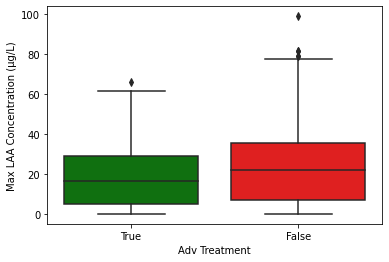

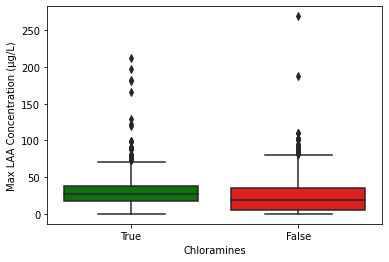

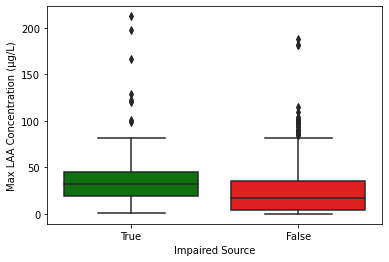

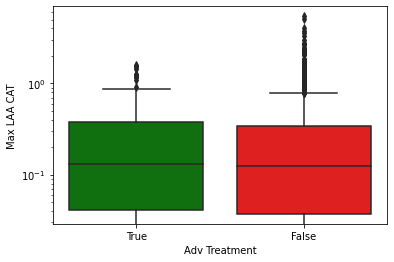

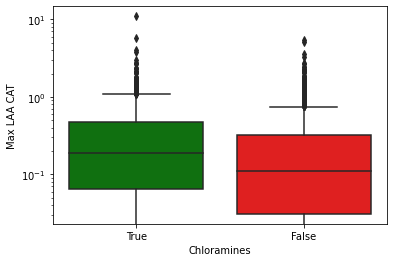

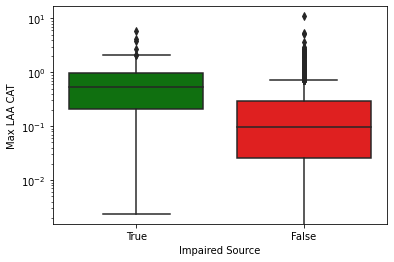

In [400]:
# Visualize the grouped results as boxplots 
my_palette = {True:'green',False:'red'}
my_order = [True, False]

plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA Concentration (µg/L)', x='Adv Treatment', palette=my_palette, order=my_order)
plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA Concentration (µg/L)', x='Chloramines', palette=my_palette, order=my_order)
plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA Concentration (µg/L)', x='Impaired Source', palette=my_palette, order=my_order)
plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA CAT', x='Adv Treatment', palette=my_palette, order=my_order).set_yscale('log')
plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA CAT', x='Chloramines', palette=my_palette, order=my_order).set_yscale('log')
plt.figure()
g = sns.boxplot(data=df_merged3, y='Max LAA CAT', x='Impaired Source', palette=my_palette, order=my_order).set_yscale('log')


In [401]:
df_merged3.to_csv("haa9_categories_pre-anova.csv")

### Export

In [402]:
## Export location and size data
# df_size_zip_c = pd.merge(left=df_size_zip, right=df_clust23_pid, on='PWSID', how='outer')
# df_size_zip_c.to_csv("PWSID_Location_Size_Cluster.csv")